#### **Import Packages**

In [1]:
# Install seaborn
%pip install seaborn
%pip install statsmodels

# Import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import statsmodels.api as sm



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 10.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 78.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 14.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


#### **Load Tables (Spark)**

In [2]:
# Date
from deltalake import DeltaTable, write_deltalake
table_path = 'abfss://Projeto_II@onelake.dfs.fabric.microsoft.com/Projeto_II_Gold_.Lakehouse/Tables/Projeto_II_Gold_/dim_date' 
storage_options = {"bearer_token": notebookutils.credentials.getToken('storage'), "use_fabric_endpoint": "true"}
date_spark = DeltaTable(table_path, storage_options=storage_options)

In [3]:
# Stores
from deltalake import DeltaTable, write_deltalake
table_path = 'abfss://Projeto_II@onelake.dfs.fabric.microsoft.com/Projeto_II_Gold_.Lakehouse/Tables/Projeto_II_Gold_/dim_stores' 
storage_options = {"bearer_token": notebookutils.credentials.getToken('storage'), "use_fabric_endpoint": "true"}
stores_spark = DeltaTable(table_path, storage_options=storage_options)

In [4]:
# Sales
from deltalake import DeltaTable, write_deltalake
table_path = 'abfss://Projeto_II@onelake.dfs.fabric.microsoft.com/Projeto_II_Gold_.Lakehouse/Tables/Projeto_II_Gold_/fact_sales' 
storage_options = {"bearer_token": notebookutils.credentials.getToken('storage'), "use_fabric_endpoint": "true"}
sales_spark = DeltaTable(table_path, storage_options=storage_options)

In [5]:
# Products
from deltalake import DeltaTable, write_deltalake
table_path = 'abfss://Projeto_II@onelake.dfs.fabric.microsoft.com/Projeto_II_Gold_.Lakehouse/Tables/Projeto_II_Gold_/dim_product' 
storage_options = {"bearer_token": notebookutils.credentials.getToken('storage'), "use_fabric_endpoint": "true"}
products_spark = DeltaTable(table_path, storage_options=storage_options)

#### **Convert to Pandas**

In [6]:
sales = sales_spark.to_pandas()
products = products_spark.to_pandas()
stores = stores_spark.to_pandas()
date = date_spark.to_pandas()

# Date type
date["full_date"] = pd.to_datetime(date["full_date"])

# Inspect
sales.info()
date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8886058 entries, 0 to 8886057
Data columns (total 13 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   date_id                int32  
 1   store_id               object 
 2   product_id             object 
 3   sales                  float64
 4   revenue                float64
 5   stock                  float64
 6   price                  float64
 7   promo_type_1           object 
 8   promo_bin_1            object 
 9   promo_type_2           object 
 10  promo_bin_2            object 
 11  promo_discount_2       float64
 12  promo_discount_type_2  object 
dtypes: float64(5), int32(1), object(7)
memory usage: 847.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1033 entries, 0 to 1032
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date_id            1033 non-null   int32         
 1   full_d

In [7]:
sns.set(font_scale = 1.4)
sns.set_style("ticks")
sns.set_palette("winter")

blue_color = "#0000FF"
insight_color = "#00FFFF"

##### **Weekly granularity**

In [8]:
# Define PoC
sales_poc = sales[sales["store_id"].isin(["S0085", "S0095", "S0080", "S0026"])]

In [9]:
# Join
sales_date = sales_poc.merge(
    date[["date_id", "full_date", "year", "month", "week_of_year", "quarter", "is_holiday"]],
    how = "right",
    on = "date_id")

# Aggregation to weekly
sales_weekly = sales_date.set_index("full_date").groupby(["store_id", "product_id"]).resample("W").agg({
    "sales": "sum",
    "revenue": "sum",
    "stock": "mean",
    "price": "mean",
    "promo_type_1": lambda x: x.mode()[0] if not x.mode().empty else None,
    "promo_bin_1": lambda x: x.mode()[0] if not x.mode().empty else None,
    "promo_type_2": lambda x: x.mode()[0] if not x.mode().empty else None,
    "promo_bin_2": lambda x: x.mode()[0] if not x.mode().empty else None,
    "promo_discount_2": "max",    # mean or max?
    "promo_discount_type_2": lambda x: x.mode()[0] if not x.mode().empty else None,
    "year": "last",
    "month": "last",
    "week_of_year": "last",
    "quarter": "last",
    "is_holiday": "max"}).reset_index()

# Rename


# Inspect
sales_weekly.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133001 entries, 0 to 133000
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   store_id               133001 non-null  object        
 1   product_id             133001 non-null  object        
 2   full_date              133001 non-null  datetime64[ns]
 3   sales                  133001 non-null  float64       
 4   revenue                133001 non-null  float64       
 5   stock                  122103 non-null  float64       
 6   price                  122103 non-null  float64       
 7   promo_type_1           122103 non-null  object        
 8   promo_bin_1            122103 non-null  object        
 9   promo_type_2           122103 non-null  object        
 10  promo_bin_2            122103 non-null  object        
 11  promo_discount_2       122103 non-null  float64       
 12  promo_discount_type_2  122103 non-null  obje

In [10]:
# Analysing missing values
problem_rows = sales_weekly[sales_weekly['stock'].isna()]
print(problem_rows.head())

    store_id product_id  full_date  sales  revenue  stock  price promo_type_1  \
250    S0026      P0007 2018-11-25    0.0      0.0    NaN    NaN         None   
251    S0026      P0007 2018-12-02    0.0      0.0    NaN    NaN         None   
252    S0026      P0007 2018-12-09    0.0      0.0    NaN    NaN         None   
253    S0026      P0007 2018-12-16    0.0      0.0    NaN    NaN         None   
254    S0026      P0007 2018-12-23    0.0      0.0    NaN    NaN         None   

    promo_bin_1 promo_type_2 promo_bin_2  promo_discount_2  \
250        None         None        None               NaN   
251        None         None        None               NaN   
252        None         None        None               NaN   
253        None         None        None               NaN   
254        None         None        None               NaN   

    promo_discount_type_2  year  month  week_of_year  quarter is_holiday  
250                  None   NaN    NaN           NaN      NaN    

###### **Notes**

- The missing values in several columns are related to sales and revenue as 0. Why 0?

In [11]:
# Analyse Promo
sales_weekly[sales_weekly["store_id"].isin(["S0085", "S0095", "S0080", "S0026"])].groupby("store_id")["promo_type_1"].value_counts()

store_id  promo_type_1
S0026     PR14            33779
          PR05             2595
          PR10              973
          PR03              607
          PR06              562
          PR07              217
          PR12              147
          PR09              136
          PR17              134
          PR01               35
          PR04               10
          PR11               10
          PR18                4
          PR08                3
          PR16                1
S0080     PR14             8531
          PR05              215
          PR10              205
          PR03              204
          PR06               99
          PR12               71
          PR07               63
          PR09               36
          PR01               33
          PR17               26
          PR04                9
          PR18                7
          PR11                4
          PR08                1
S0085     PR14            41234
          PR05   

In [12]:
# Define each dataframe

sales_weekly = sales_weekly.merge(
    products,
    how = "left",
    on = "product_id")

sales_weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133001 entries, 0 to 133000
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   store_id               133001 non-null  object        
 1   product_id             133001 non-null  object        
 2   full_date              133001 non-null  datetime64[ns]
 3   sales                  133001 non-null  float64       
 4   revenue                133001 non-null  float64       
 5   stock                  122103 non-null  float64       
 6   price                  122103 non-null  float64       
 7   promo_type_1           122103 non-null  object        
 8   promo_bin_1            122103 non-null  object        
 9   promo_type_2           122103 non-null  object        
 10  promo_bin_2            122103 non-null  object        
 11  promo_discount_2       122103 non-null  float64       
 12  promo_discount_type_2  122103 non-null  obje

In [13]:
# Create Functions

# Create a new dataframe for each store
def store_total(store_id, define_h1 = ["H00", "H01", "H02", "H03"]):
    """ Creates a new dataframe for each store with variables aggregated by the full_date for each store individually."""

    store_number = sales_weekly[sales_weekly["store_id"] == store_id]
    store_number = sales_weekly[sales_weekly["hierarchy1_id"].isin(define_h1)]
    store_number = pd.get_dummies(store_number, columns = ["promo_type_1"])
    store_number = pd.get_dummies(store_number, columns = ["promo_type_2"])
    store_dataframe = store_number.groupby("full_date").agg(
        {"sales": "sum",
        "stock": "mean",
        "revenue": "sum",
        "price": "mean",
        "promo_type_1_PR03": "max",
        "promo_type_1_PR05": "max",
        "promo_type_1_PR14": "max",
        "promo_type_1_PR06": "max",
        "promo_type_1_PR18": "max",
        "promo_type_2_PR03": "max",
        "promo_bin_1": lambda x: x.mode()[0] if not x.mode().empty else None,
        "promo_bin_2": lambda x: x.mode()[0] if not x.mode().empty else None,
        "promo_discount_2": "max",
        "promo_discount_type_2": lambda x: x.mode()[0] if not x.mode().empty else None,
        "is_holiday": "max",
        "week_of_year": "last",
        "year": "last",
        "month": "last",
        "quarter": "last"})
    store_dataframe["sales_wow_change"] = store_dataframe["sales"].pct_change() * 100
    
    return store_dataframe 

In [14]:
# Apply Functions: Stores
store85_df = store_total("S0085")
store95_df = store_total("S0095")
store80_df = store_total("S0080")
store26_df = store_total("S0026")

store85_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148 entries, 2017-01-08 to 2019-11-03
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sales                  148 non-null    float64
 1   stock                  148 non-null    float64
 2   revenue                148 non-null    float64
 3   price                  148 non-null    float64
 4   promo_type_1_PR03      148 non-null    bool   
 5   promo_type_1_PR05      148 non-null    bool   
 6   promo_type_1_PR14      148 non-null    bool   
 7   promo_type_1_PR06      148 non-null    bool   
 8   promo_type_1_PR18      148 non-null    bool   
 9   promo_type_2_PR03      148 non-null    bool   
 10  promo_bin_1            148 non-null    object 
 11  promo_bin_2            148 non-null    object 
 12  promo_discount_2       148 non-null    float64
 13  promo_discount_type_2  148 non-null    object 
 14  is_holiday             148 non-null    

#### **Holidays**

In [15]:
# Define Function
# Visualization of holidays impact
#"Weekly Sales and Holidays of Store S0085 (ST01)"
def plot_holidays(dataframe, title):
    """ Plot the impact of weeks with and without holidays in total sales."""
    sns.relplot(
    data = dataframe,
    x = "full_date",
    y = "sales",
    palette = "Blues",
    hue = "is_holiday")
    plt.xticks(rotation = 45)
    plt.title(title)
    plt.show() 

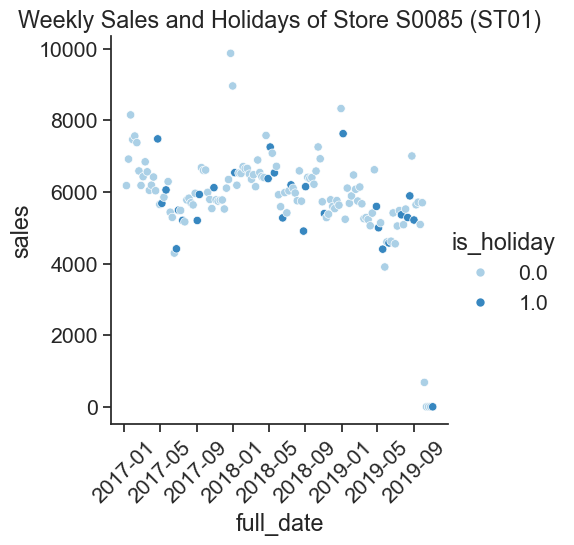

In [16]:
# Apply Functions: Store S0085
plot_holidays(store85_df, "Weekly Sales and Holidays of Store S0085 (ST01)")

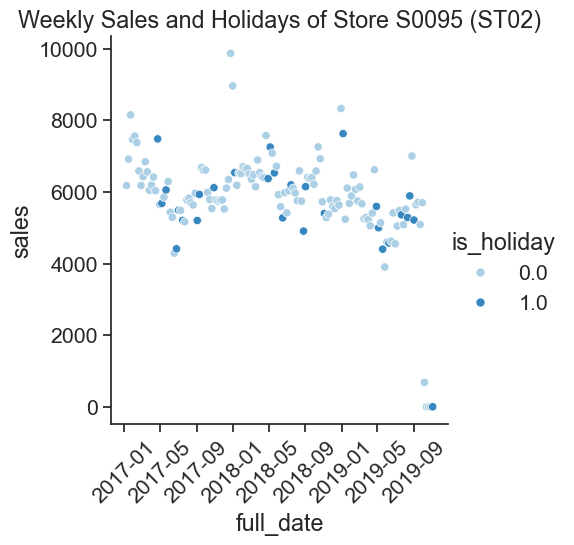

In [17]:
# Apply Functions: Store S0095
plot_holidays(store95_df, "Weekly Sales and Holidays of Store S0095 (ST02)")

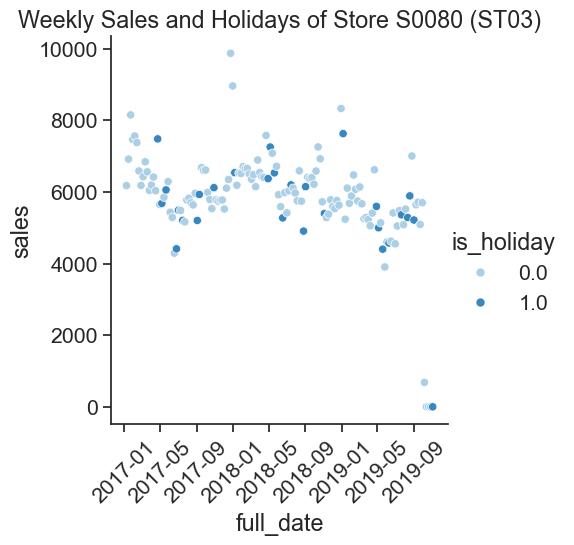

In [18]:
# Apply Functions: Store S0080
plot_holidays(store80_df, "Weekly Sales and Holidays of Store S0080 (ST03)")

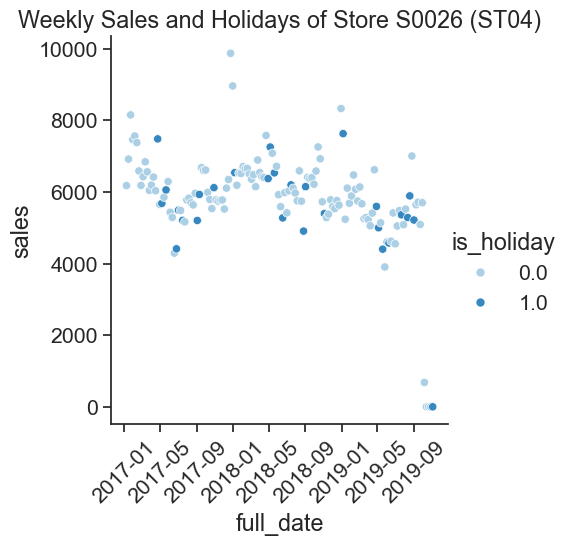

In [19]:
# Apply Functions: Store S0026
plot_holidays(store26_df, "Weekly Sales and Holidays of Store S0026 (ST04)")

#### **Sales, Revenue, Stock and Full Date**

In [20]:
# Describe
print(store85_df[["sales", "revenue", "stock"]].describe().round(2))

         sales   revenue   stock
count   148.00    148.00  148.00
mean   5817.96  30561.93   24.05
std    1361.64  10418.35    5.14
min       0.00      0.00    0.00
25%    5414.43  24892.86   22.94
50%    5887.53  29553.82   24.69
75%    6473.34  34646.04   26.09
max    9869.18  89422.36   35.79


In [21]:
# Describe
print(store95_df[["sales", "revenue", "stock"]].describe().round(2))

         sales   revenue   stock
count   148.00    148.00  148.00
mean   5817.96  30561.93   24.05
std    1361.64  10418.35    5.14
min       0.00      0.00    0.00
25%    5414.43  24892.86   22.94
50%    5887.53  29553.82   24.69
75%    6473.34  34646.04   26.09
max    9869.18  89422.36   35.79


In [22]:
# Describe
print(store80_df[["sales", "revenue", "stock"]].describe().round(2))

         sales   revenue   stock
count   148.00    148.00  148.00
mean   5817.96  30561.93   24.05
std    1361.64  10418.35    5.14
min       0.00      0.00    0.00
25%    5414.43  24892.86   22.94
50%    5887.53  29553.82   24.69
75%    6473.34  34646.04   26.09
max    9869.18  89422.36   35.79


In [23]:
# Describe
print(store26_df[["sales", "revenue", "stock"]].describe().round(2))

         sales   revenue   stock
count   148.00    148.00  148.00
mean   5817.96  30561.93   24.05
std    1361.64  10418.35    5.14
min       0.00      0.00    0.00
25%    5414.43  24892.86   22.94
50%    5887.53  29553.82   24.69
75%    6473.34  34646.04   26.09
max    9869.18  89422.36   35.79


#### **Products**

In [24]:
# Define dataframes with all products
store85_prod = sales_weekly[sales_weekly["store_id"] == "S0085"]
store95_prod = sales_weekly[sales_weekly["store_id"] == "S0095"]
store80_prod = sales_weekly[sales_weekly["store_id"] == "S0080"]
store26_prod = sales_weekly[sales_weekly["store_id"] == "S0026"]

store85_prod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51452 entries, 53631 to 105082
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   store_id               51452 non-null  object        
 1   product_id             51452 non-null  object        
 2   full_date              51452 non-null  datetime64[ns]
 3   sales                  51452 non-null  float64       
 4   revenue                51452 non-null  float64       
 5   stock                  47650 non-null  float64       
 6   price                  47650 non-null  float64       
 7   promo_type_1           47650 non-null  object        
 8   promo_bin_1            47650 non-null  object        
 9   promo_type_2           47650 non-null  object        
 10  promo_bin_2            47650 non-null  object        
 11  promo_discount_2       47650 non-null  float64       
 12  promo_discount_type_2  47650 non-null  object        
 13  y

In [25]:
# Nº of products
for store in [store85_prod, store95_prod, store80_prod, store26_prod]:
    print(store["product_id"].nunique())


556
304
137
497


In [26]:
# Top 10 Products by Revenue 

# Define Functions

# Top 10
def top10_products(dataframe):
    """ Select the top 10 products in each store in terms of revenue"""
    prod_top10 = (dataframe.groupby(
    ["product_id", "hierarchy1_id"])["revenue"].sum().sort_values(
        ascending = False).head(10) / dataframe["revenue"].sum() * 100).reset_index()
    return prod_top10


# Visualization
#"Top 10 Products with Highest Revenue of Store S0085 (ST01)"
def plot_top10_products(dataframe, title):
    sns.catplot(
    data = dataframe,
    x = "product_id",
    y = "revenue",
    palette = "Blues",
    hue = "hierarchy1_id",
    kind = "bar")
    plt.ylabel("Revenue (%)")
    plt.xticks(rotation = 45)
    plt.title(title)
    plt.show()

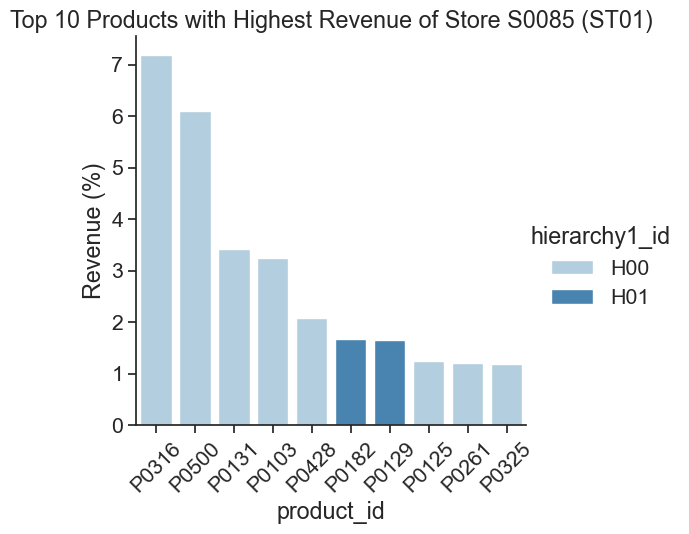

In [27]:
# Apply functions: S0085
top10_prod_st85 = top10_products(store85_prod)
plot_top10_products(top10_prod_st85, "Top 10 Products with Highest Revenue of Store S0085 (ST01)")

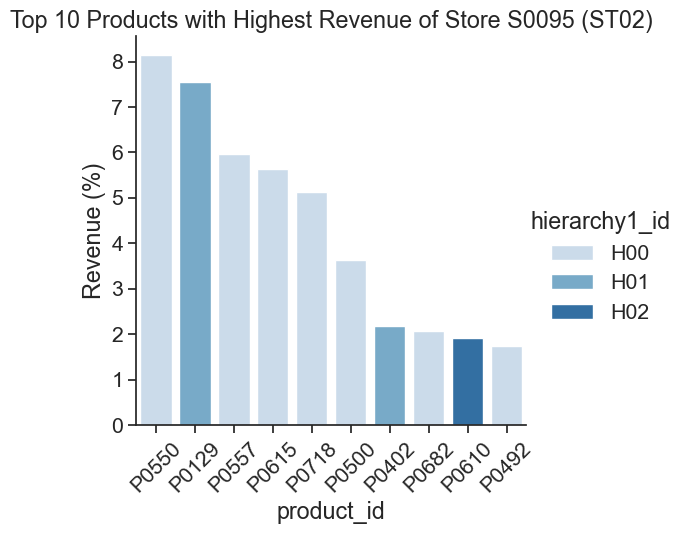

In [28]:
# Apply functions: S0095
top10_prod_st95 = top10_products(store95_prod)
plot_top10_products(top10_prod_st95, "Top 10 Products with Highest Revenue of Store S0095 (ST02)")

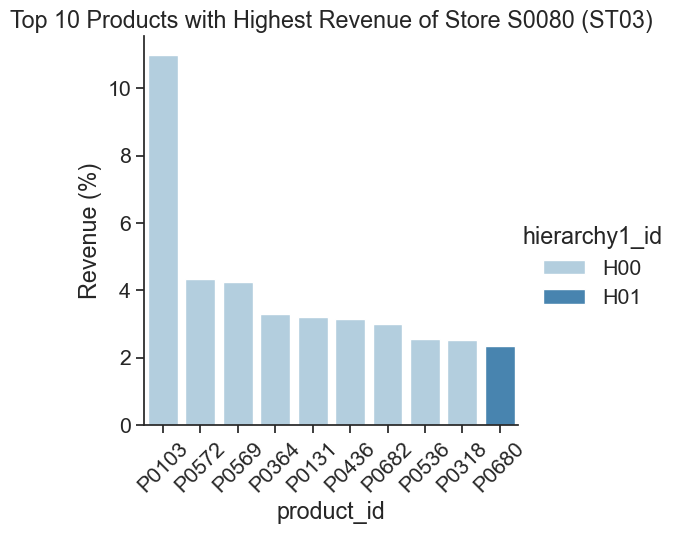

In [29]:
# Apply functions: S0080
top10_prod_st80 = top10_products(store80_prod)
plot_top10_products(top10_prod_st80, "Top 10 Products with Highest Revenue of Store S0080 (ST03)")

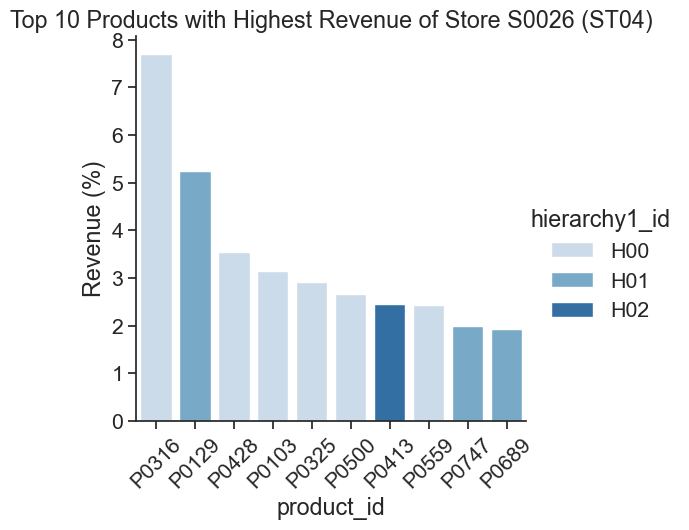

In [30]:
# Apply functions: S0026
top10_prod_st26 = top10_products(store26_prod)
plot_top10_products(top10_prod_st26, "Top 10 Products with Highest Revenue of Store S0026 (ST04)")

#### **Price**

In [31]:
# Define function: histogram 
def price_hist(dataframe):
    sns.displot(
        data = dataframe,
        x = "price",
        kind = "hist")
    plt.show()

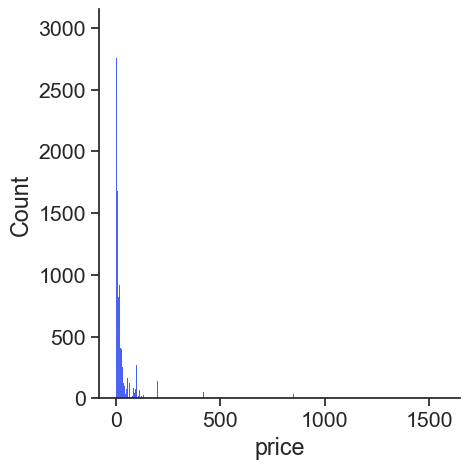

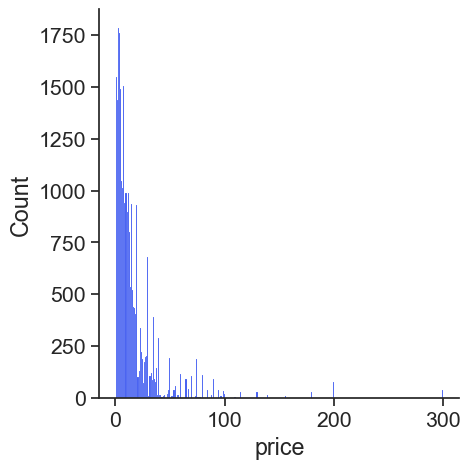

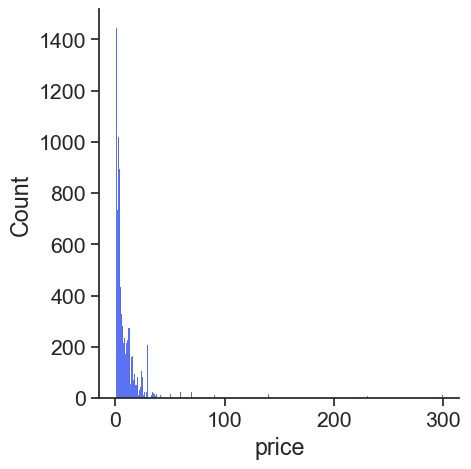

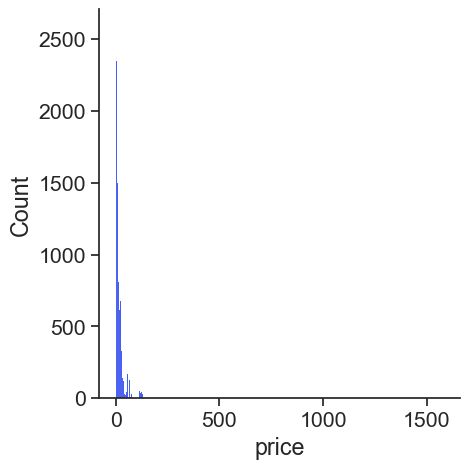

In [32]:
# Apply function
price_hist(store85_prod)
price_hist(store95_prod)
price_hist(store80_prod)
price_hist(store26_prod)

#### **Promo**

In [33]:
# Define Function: Plot

# Visualization
#"Weekly Sales Change and Max. Discount of Store S0085 (ST01)"
def plot_promo(dataframe, promo, title):
    sns.relplot(
        data = dataframe,
        y = "sales_wow_change",
        x = "full_date",
        palette = "Blues_r",
        hue = promo)
    plt.xticks(rotation = 45)
    plt.ylabel("Change (%)")
    plt.title(title)
    plt.show()


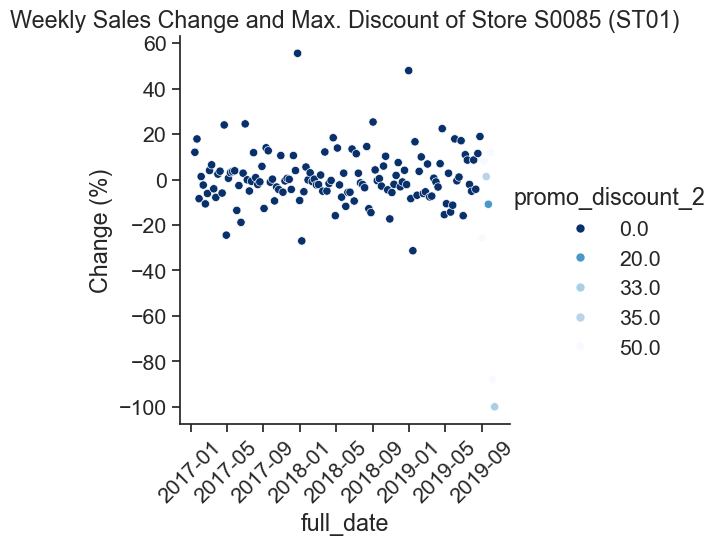

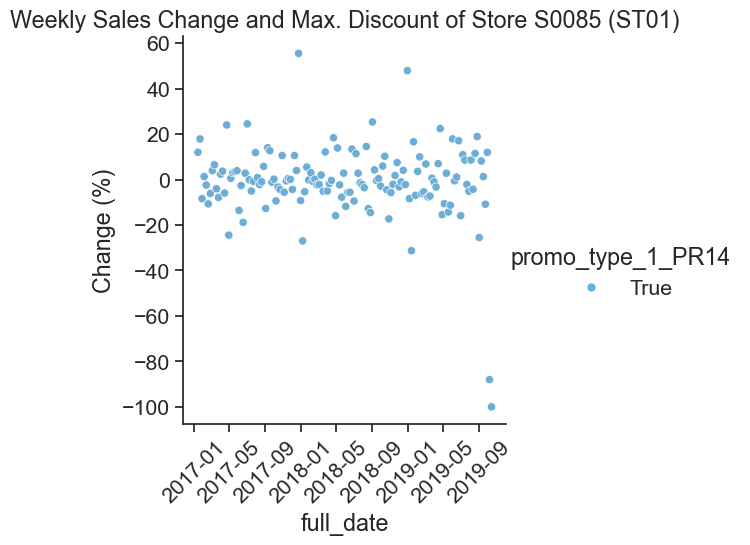

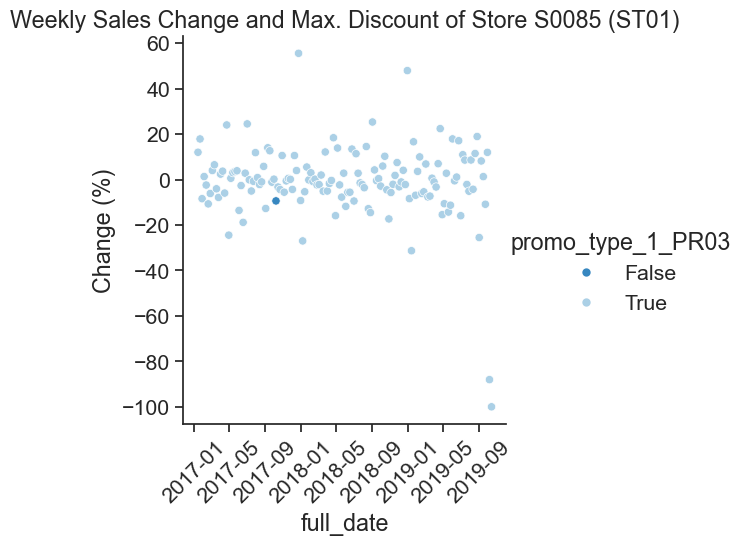

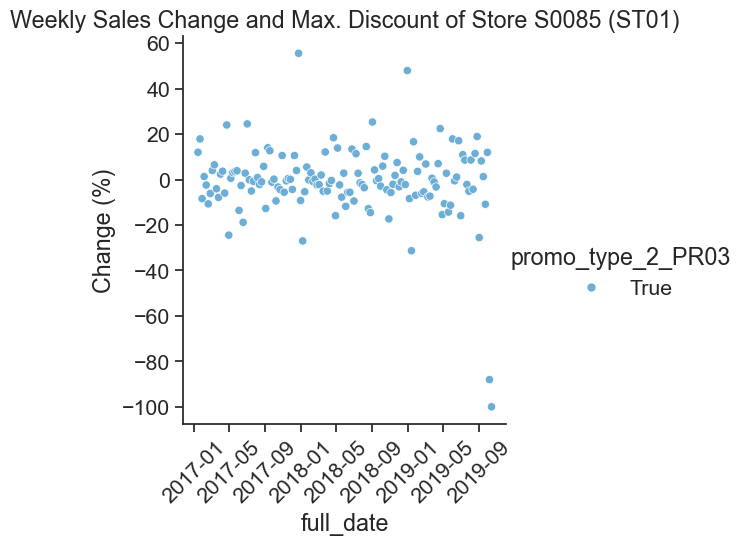

In [34]:
# Apply Functions: S0085

plot_promo(
    store85_df, 
    "promo_discount_2", 
    "Weekly Sales Change and Max. Discount of Store S0085 (ST01)")


plot_promo(
    store85_df, 
    "promo_type_1_PR14", 
    "Weekly Sales Change and Max. Discount of Store S0085 (ST01)")

plot_promo(
    store85_df, 
    "promo_type_1_PR03", 
    "Weekly Sales Change and Max. Discount of Store S0085 (ST01)")

plot_promo(
    store85_df, 
    "promo_type_2_PR03", 
    "Weekly Sales Change and Max. Discount of Store S0085 (ST01)")

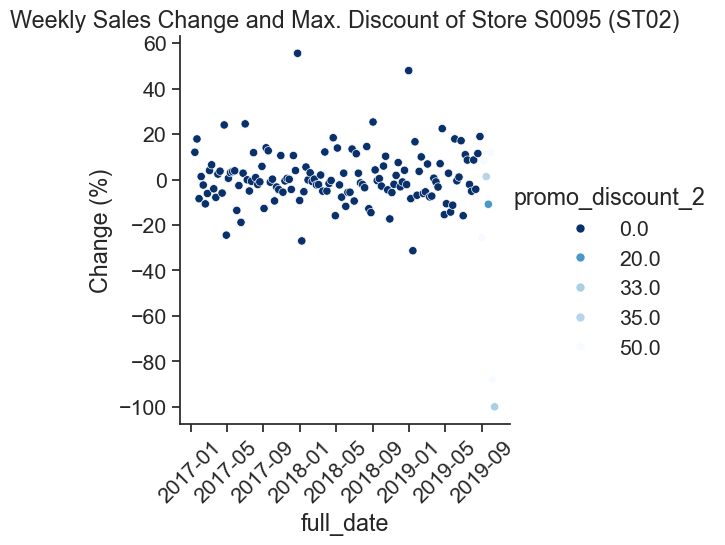

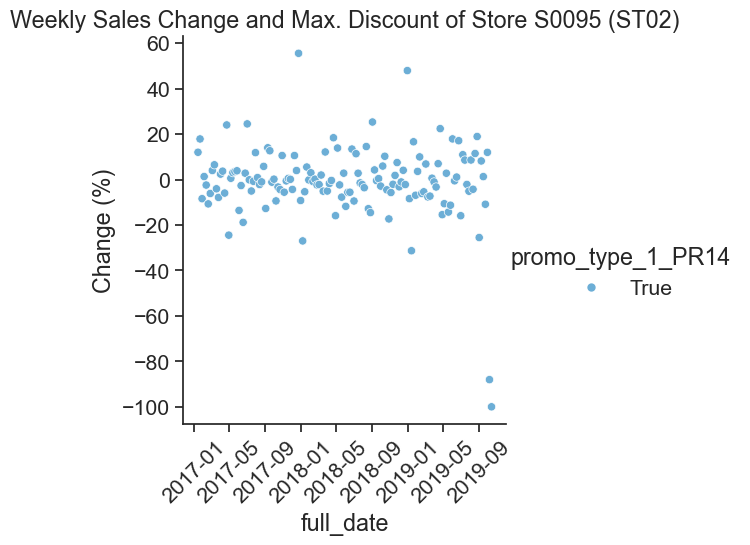

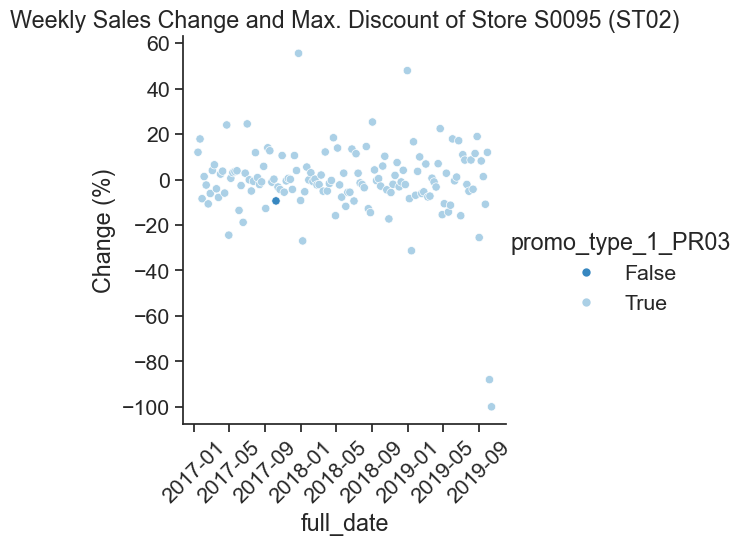

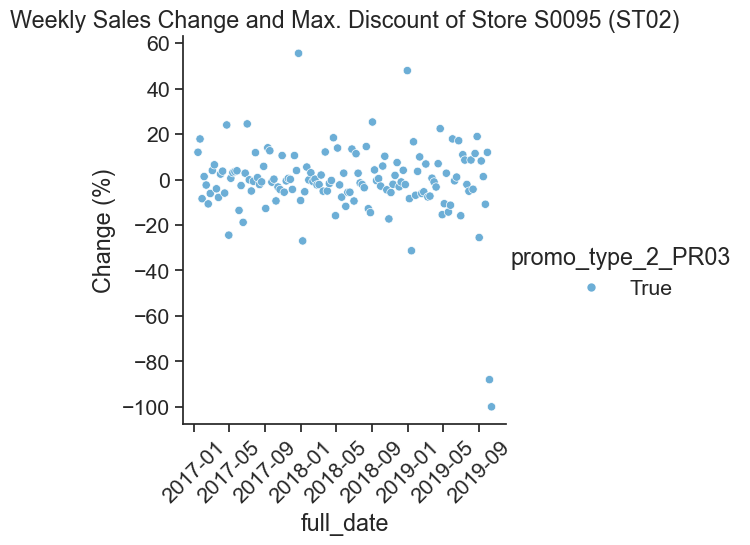

In [35]:
# Apply Functions: S0095

plot_promo(
    store95_df, 
    "promo_discount_2", 
    "Weekly Sales Change and Max. Discount of Store S0095 (ST02)")

plot_promo(
    store95_df, 
    "promo_type_1_PR14", 
    "Weekly Sales Change and Max. Discount of Store S0095 (ST02)")

plot_promo(
    store95_df, 
    "promo_type_1_PR03", 
    "Weekly Sales Change and Max. Discount of Store S0095 (ST02)")

plot_promo(
    store95_df, 
    "promo_type_2_PR03", 
    "Weekly Sales Change and Max. Discount of Store S0095 (ST02)")

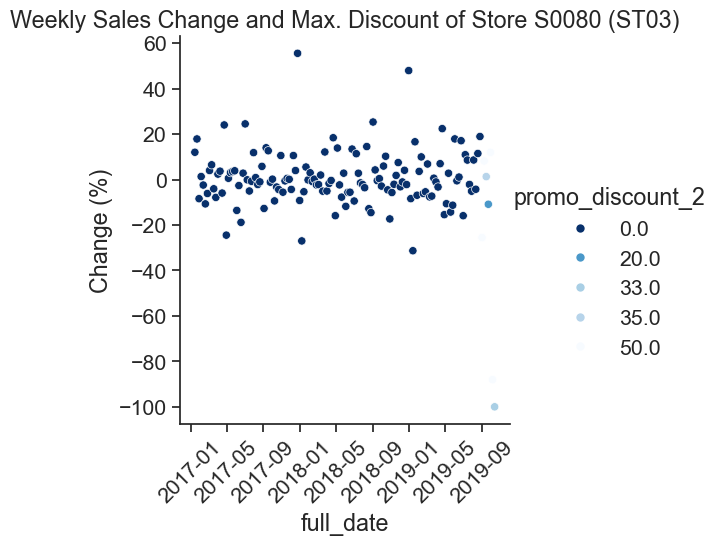

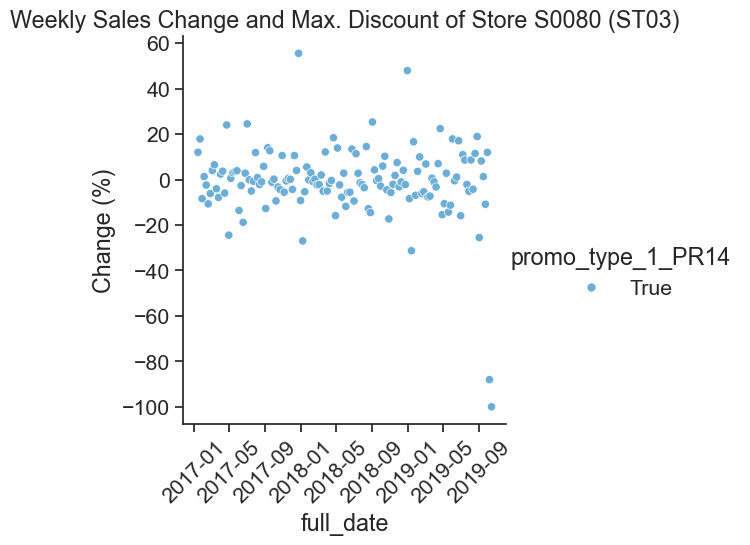

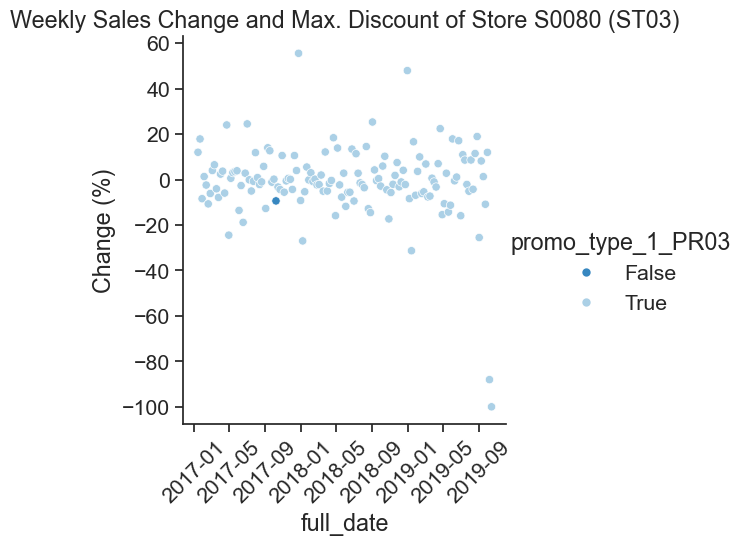

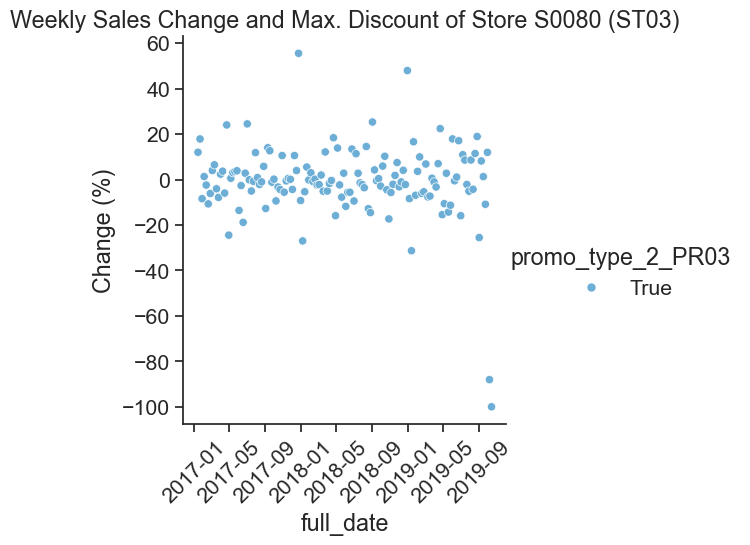

In [36]:
# Apply Functions: S0080

plot_promo(
    store80_df, 
    "promo_discount_2", 
    "Weekly Sales Change and Max. Discount of Store S0080 (ST03)")


plot_promo(
    store80_df, 
    "promo_type_1_PR14", 
    "Weekly Sales Change and Max. Discount of Store S0080 (ST03)")

plot_promo(
    store80_df, 
    "promo_type_1_PR03", 
    "Weekly Sales Change and Max. Discount of Store S0080 (ST03)")

plot_promo(
    store80_df, 
    "promo_type_2_PR03", 
    "Weekly Sales Change and Max. Discount of Store S0080 (ST03)")

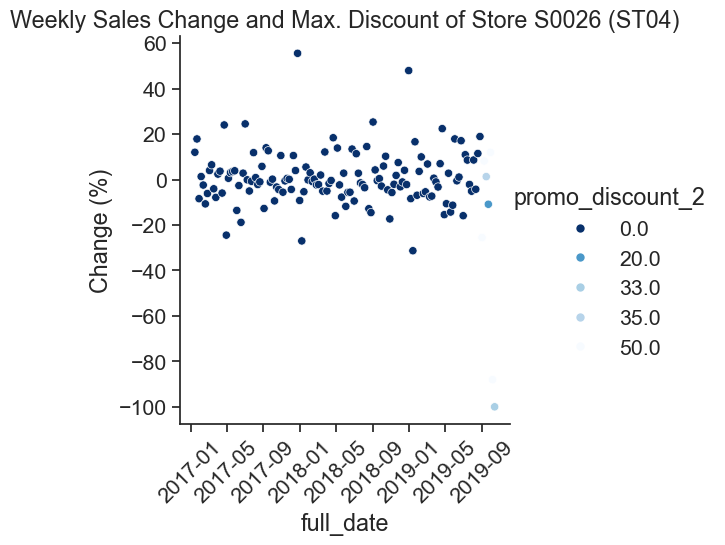

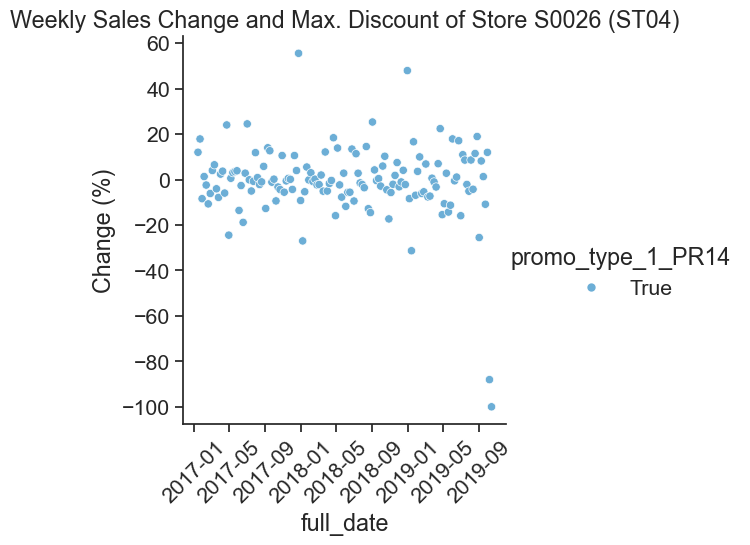

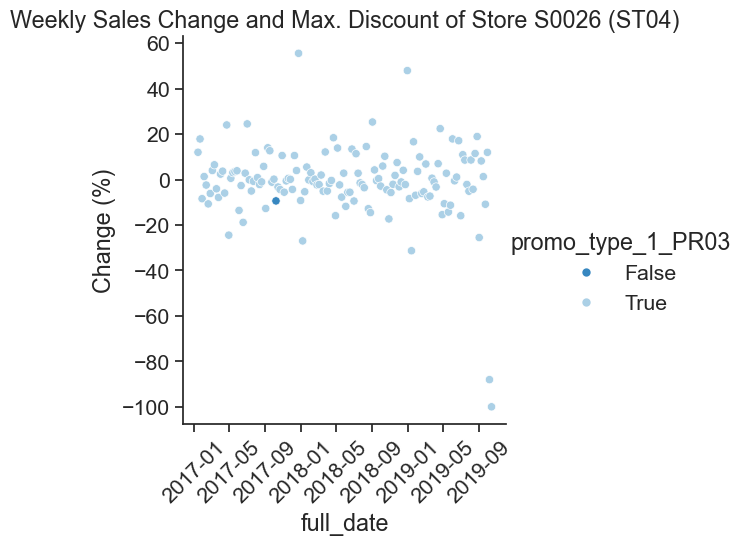

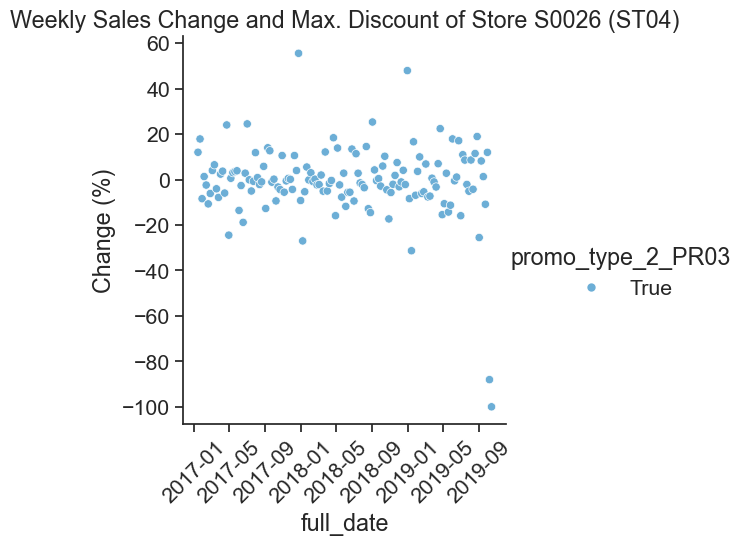

In [37]:
# Apply Functions: S0026

plot_promo(
    store26_df, 
    "promo_discount_2", 
    "Weekly Sales Change and Max. Discount of Store S0026 (ST04)")

plot_promo(
    store26_df, 
    "promo_type_1_PR14", 
    "Weekly Sales Change and Max. Discount of Store S0026 (ST04)")

plot_promo(
    store26_df, 
    "promo_type_1_PR03", 
    "Weekly Sales Change and Max. Discount of Store S0026 (ST04)")

plot_promo(
    store26_df, 
    "promo_type_2_PR03", 
    "Weekly Sales Change and Max. Discount of Store S0026 (ST04)")

In [38]:
### delete products with no sales nor stock

#### **Hierarchy 1**

In [39]:
store85_prod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51452 entries, 53631 to 105082
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   store_id               51452 non-null  object        
 1   product_id             51452 non-null  object        
 2   full_date              51452 non-null  datetime64[ns]
 3   sales                  51452 non-null  float64       
 4   revenue                51452 non-null  float64       
 5   stock                  47650 non-null  float64       
 6   price                  47650 non-null  float64       
 7   promo_type_1           47650 non-null  object        
 8   promo_bin_1            47650 non-null  object        
 9   promo_type_2           47650 non-null  object        
 10  promo_bin_2            47650 non-null  object        
 11  promo_discount_2       47650 non-null  float64       
 12  promo_discount_type_2  47650 non-null  object        
 13  y

In [40]:
# Hierarchy1
print(store85_prod["hierarchy1_id"].unique())
print(store95_prod["hierarchy1_id"].unique())
print(store80_prod["hierarchy1_id"].unique())
print(store26_prod["hierarchy1_id"].unique())

['H01' 'H03' 'H00' 'H02']
['H03' 'H00' 'H01' 'H02']
['H00' 'H03' 'H01' 'H02']
['H01' 'H03' 'H00' 'H02']


In [41]:
# Define Functions

# Frequency
def h1_frequency(dataframe):
    h1_freq = (dataframe["hierarchy1_id"].value_counts(
        normalize = True) * 100).reset_index(name = "count")
    return h1_freq

# Visualization
#"Hierarchy 1 Distribution of Store S0085 (ST01)"
def plot_h1(dataframe, title): 
    sns.catplot(
        data = dataframe,
        x = "hierarchy1_id",
        y = "count",
        color = "blue",
        kind = "bar")
    plt.title(title)
    plt.show()

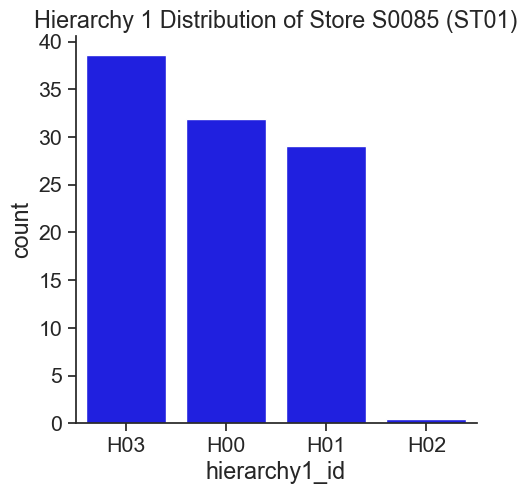

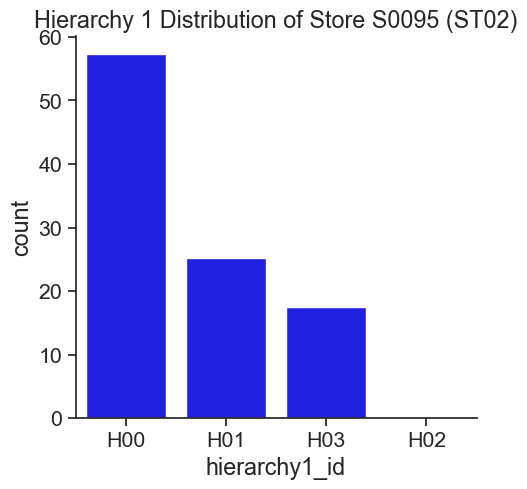

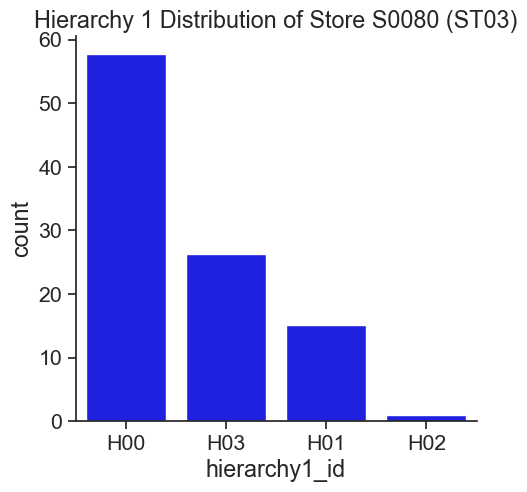

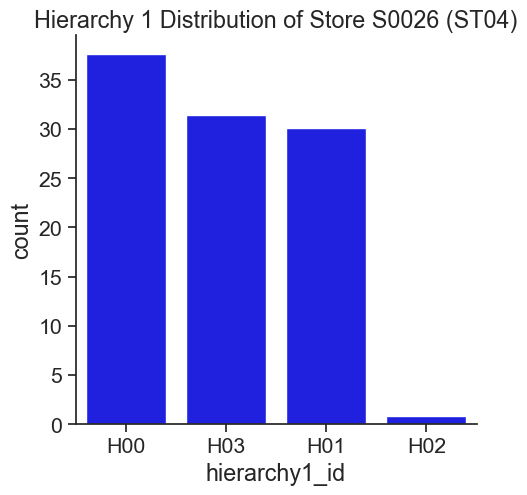

In [42]:
# Apply functions
h1_freq_st85 = h1_frequency(store85_prod)
plot_h1(h1_freq_st85, "Hierarchy 1 Distribution of Store S0085 (ST01)")

h1_freq_st95 = h1_frequency(store95_prod)
plot_h1(h1_freq_st95, "Hierarchy 1 Distribution of Store S0095 (ST02)")

h1_freq_st80 = h1_frequency(store80_prod)
plot_h1(h1_freq_st80, "Hierarchy 1 Distribution of Store S0080 (ST03)")

h1_freq_st26 = h1_frequency(store26_prod)
plot_h1(h1_freq_st26, "Hierarchy 1 Distribution of Store S0026 (ST04)")

In [43]:
# Describe
for store in [store85_prod, store95_prod, store80_prod, store26_prod]:
    print(store.groupby("hierarchy1_id")[[
        "sales", "revenue", "price"]].describe().round(2).T)
    print("\n")

hierarchy1_id       H00       H01      H02       H03
sales   count  16400.00  14943.00   230.00  19879.00
        mean      20.80      3.02    16.46      1.61
        std       62.40      8.28    26.10      5.54
        min        0.00      0.00     0.00      0.00
        25%        1.00      0.00     0.00      0.00
        50%        5.00      1.00     0.00      0.00
        75%       16.00      3.00    29.46      1.00
        max     1145.00    508.00   135.58    284.00
revenue count  16400.00  14943.00   230.00  19879.00
        mean      67.37     39.42    98.48     18.22
        std      293.30    144.28   164.38     87.10
        min        0.00      0.00     0.00      0.00
        25%        3.75      0.00     0.00      0.00
        50%       20.24     12.92     0.00      0.00
        75%       54.21     43.86   165.67      9.90
        max    21843.61  11602.21  1135.01   5812.73
price   count  15854.00  14287.00   146.00  17363.00
        mean       7.87     22.67     6.18    

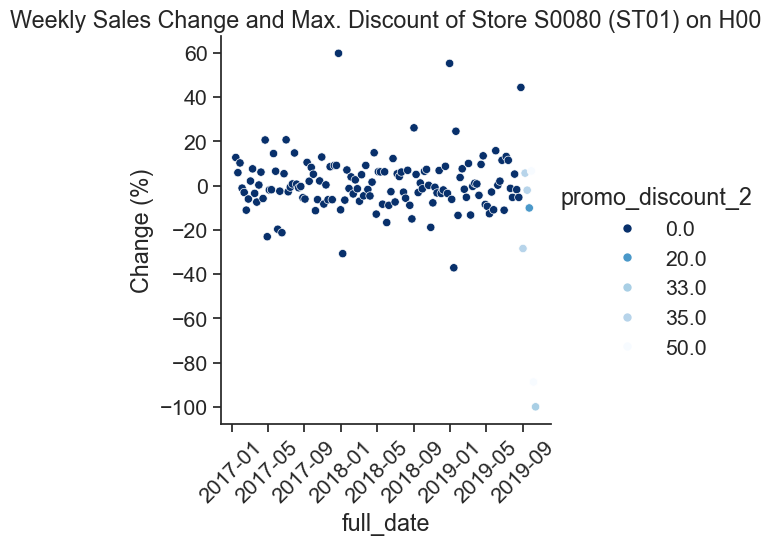

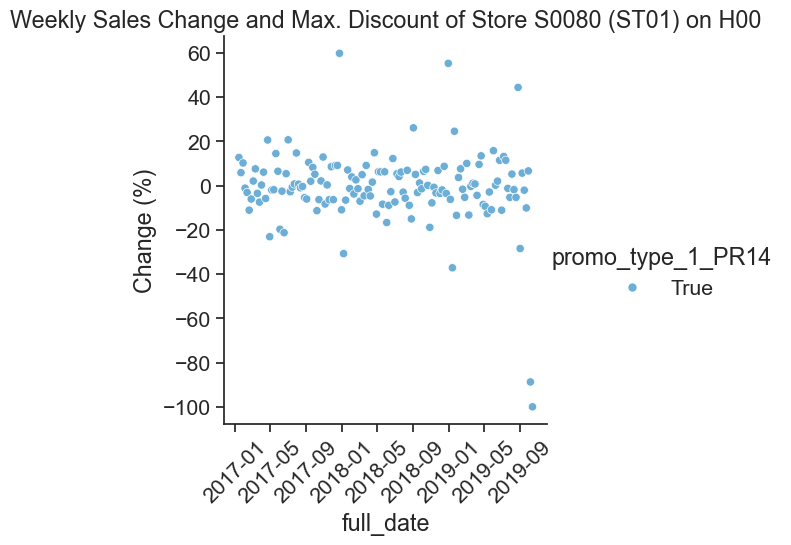

In [44]:
# Hierarchy 1 and Promo

# ST0080
store26_h00_df = store_total("ST0080", define_h1 = ["H00"])
plot_promo(
    store26_h00_df, 
    "promo_discount_2", 
    "Weekly Sales Change and Max. Discount of Store S0080 (ST01) on H00")

# ST0080
store26_h00_df = store_total("ST0080", define_h1 = ["H00"])
plot_promo(
    store26_h00_df, 
    "promo_type_1_PR14", 
    "Weekly Sales Change and Max. Discount of Store S0080 (ST01) on H00")


##### **Sales and Stock**

In [45]:
# Define Functions

def store_melted_sales_stock_h1(dataframe):
    store_analysis_melted = dataframe.melt(
    id_vars = ["full_date", "hierarchy1_id"],
    value_vars = ["stock", "sales"],         
    var_name = "feature",
    value_name = "value")
    return store_analysis_melted

# "Store S0085 (ST01)"
def plot_store_melted_sales_stock_h1(dataframe, title):
    g = sns.relplot(
        data = dataframe,
        x = "full_date",
        y = "value",           
        col = "hierarchy1_id",
        hue = "feature",  
        palette = "Blues",
        errorbar = ("ci", False),      
        kind = "line",
        col_order = ["H00", "H01", "H02", "H03"])
    g.set_xticklabels(rotation = 45)
    g.fig.suptitle(title, y = 1.03)
    plt.show()

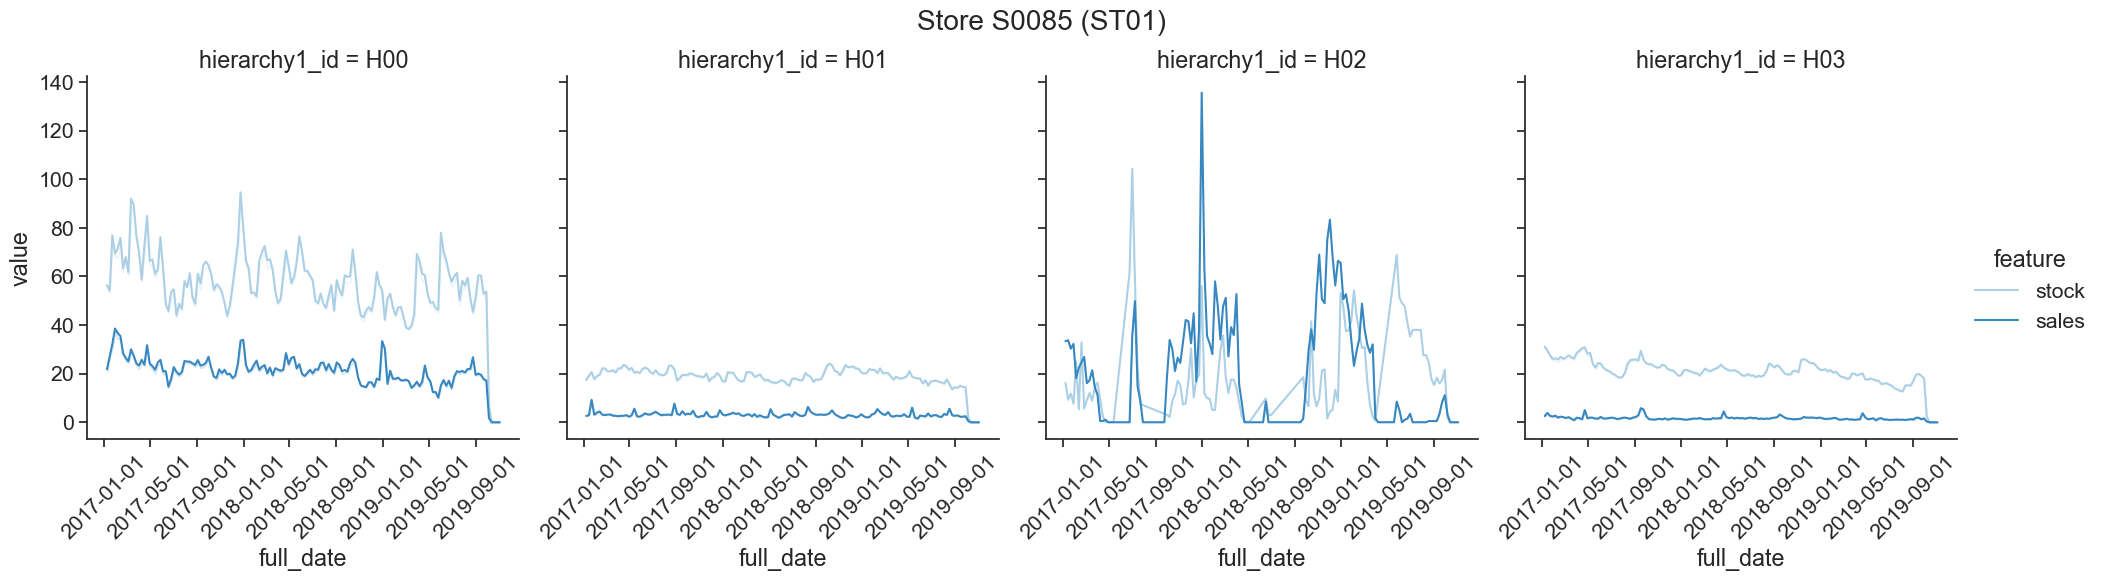

In [46]:
# ST0085
store85_df_sales_stock = store_melted_sales_stock_h1(store85_prod)
plot_store_melted_sales_stock_h1(store85_df_sales_stock, "Store S0085 (ST01)")

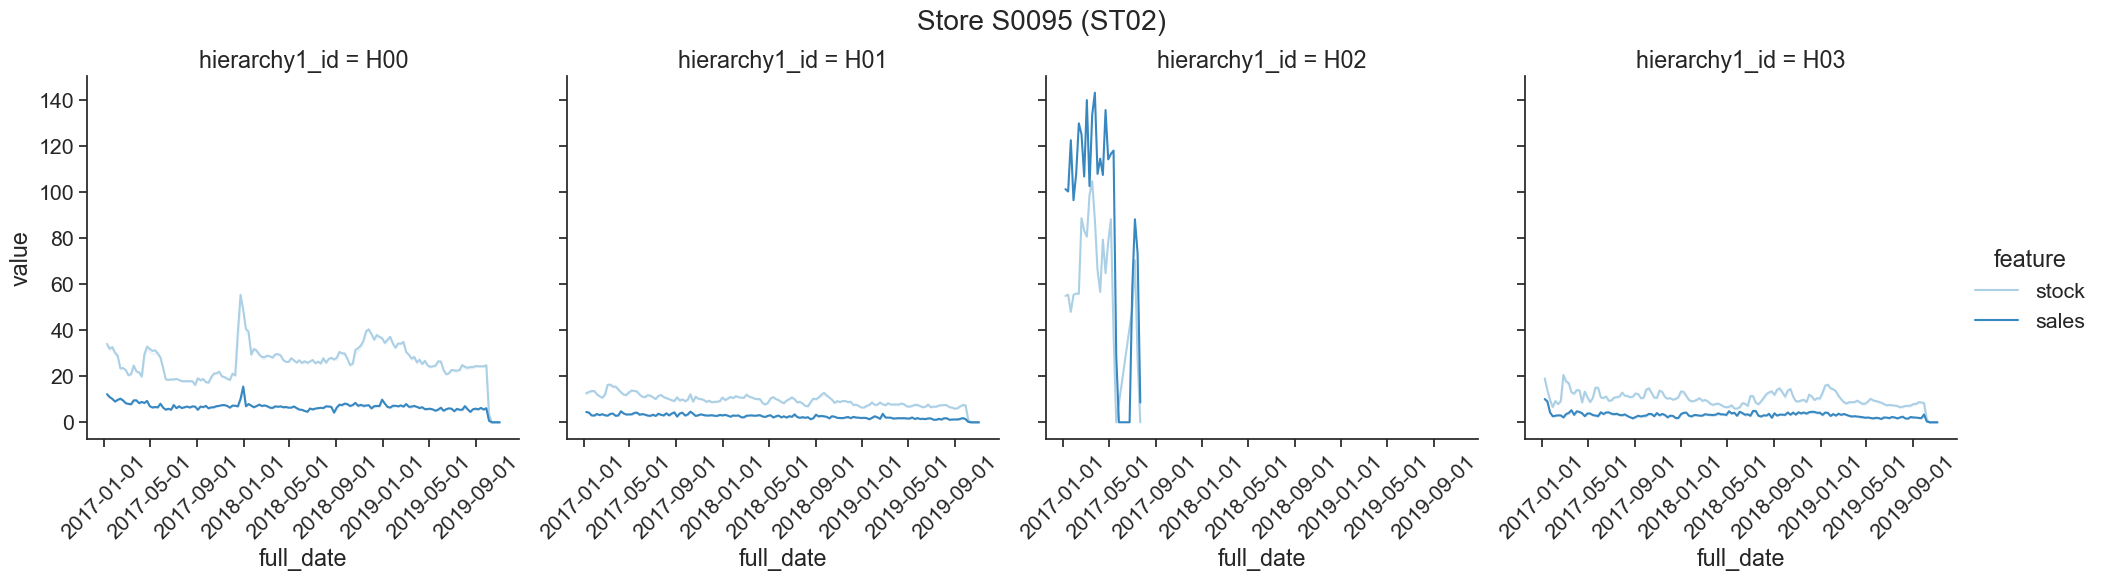

In [47]:
# ST0095
store95_df_sales_stock = store_melted_sales_stock_h1(store95_prod)
plot_store_melted_sales_stock_h1(store95_df_sales_stock, "Store S0095 (ST02)")

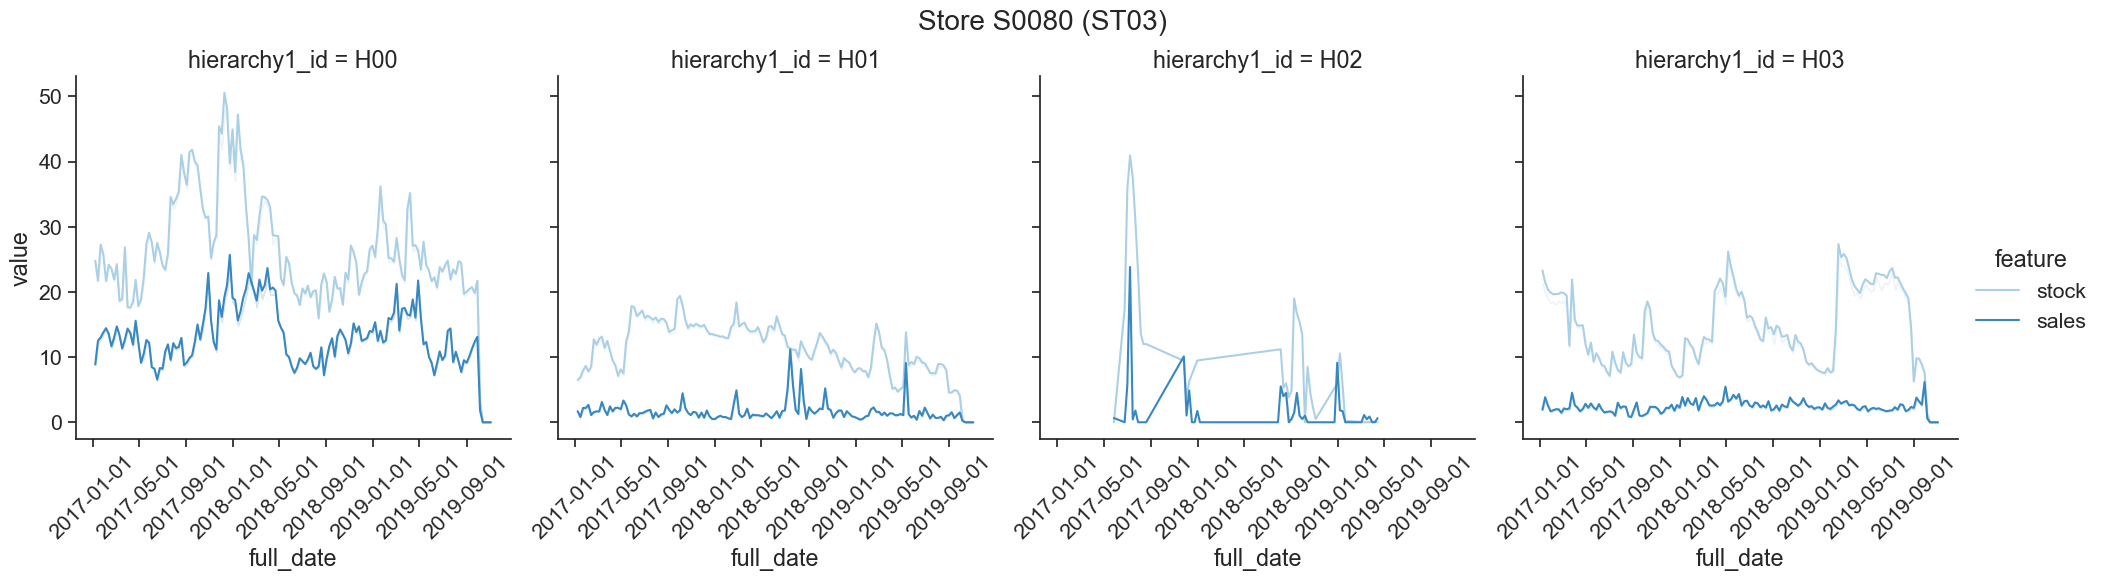

In [48]:
# ST0080
store80_df_sales_stock = store_melted_sales_stock_h1(store80_prod)
plot_store_melted_sales_stock_h1(store80_df_sales_stock, "Store S0080 (ST03)")

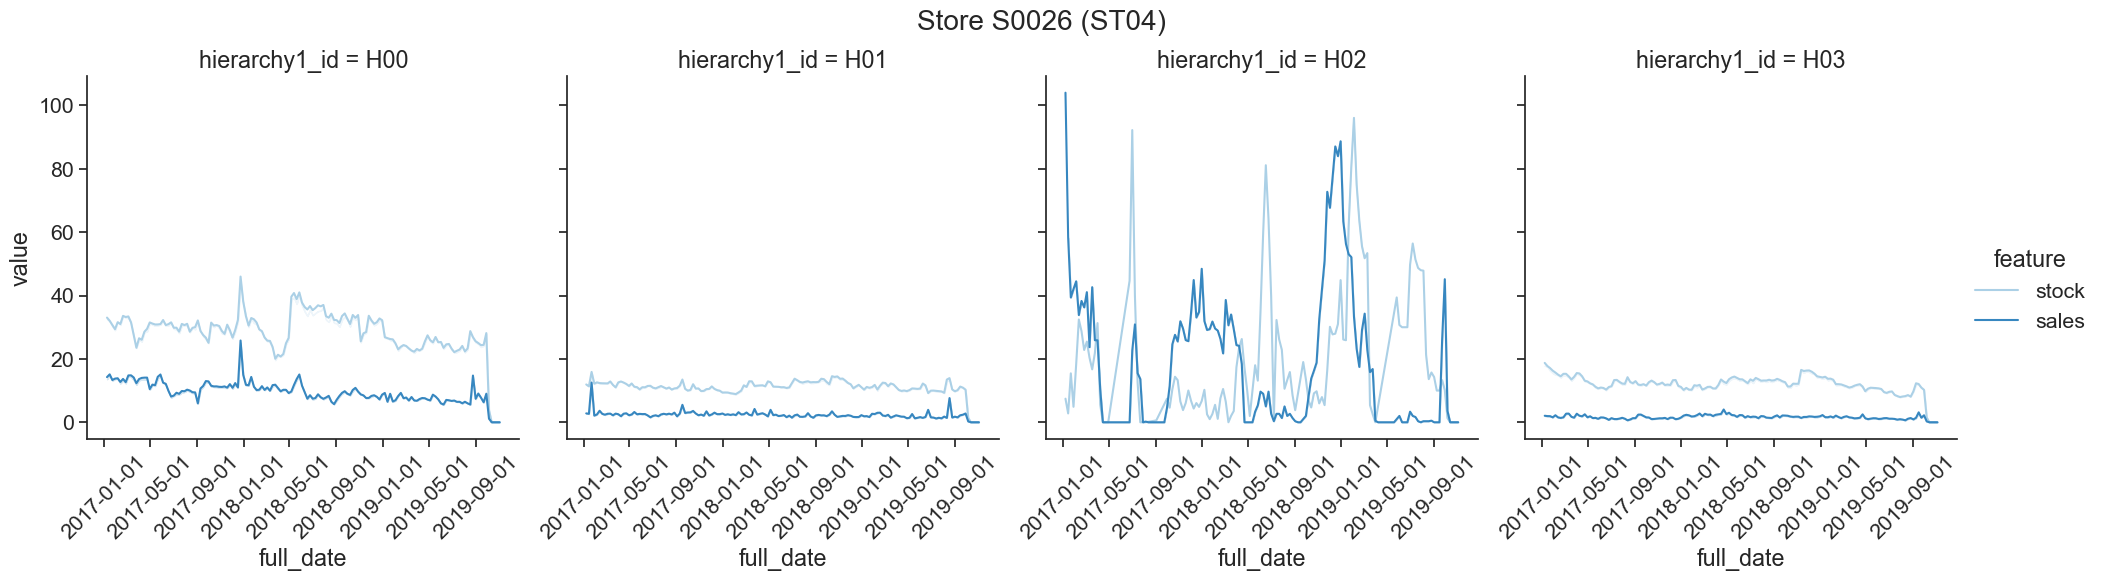

In [49]:
# ST0026
store26_df_sales_stock = store_melted_sales_stock_h1(store26_prod)
plot_store_melted_sales_stock_h1(store26_df_sales_stock, "Store S0026 (ST04)")

##### **Correlation**

In [50]:
# Correlation
for store in [store85_df, store95_df, store80_df, store26_df]:
    print(store[["sales", "stock", "revenue", "price", "promo_discount_2"]].corr())
    print("\n")

                     sales     stock   revenue     price  promo_discount_2
sales             1.000000  0.870667  0.565531 -0.462758         -0.398989
stock             0.870667  1.000000  0.363501 -0.583778         -0.470214
revenue           0.565531  0.363501  1.000000  0.309356         -0.110603
price            -0.462758 -0.583778  0.309356  1.000000          0.430229
promo_discount_2 -0.398989 -0.470214 -0.110603  0.430229          1.000000


                     sales     stock   revenue     price  promo_discount_2
sales             1.000000  0.870667  0.565531 -0.462758         -0.398989
stock             0.870667  1.000000  0.363501 -0.583778         -0.470214
revenue           0.565531  0.363501  1.000000  0.309356         -0.110603
price            -0.462758 -0.583778  0.309356  1.000000          0.430229
promo_discount_2 -0.398989 -0.470214 -0.110603  0.430229          1.000000


                     sales     stock   revenue     price  promo_discount_2
sales             1.0

##### **Trend, Tendency and Noise**

In [51]:
# Decomposition

# Define Function
# "Time Series Decomposition of Store S0085 (ST01) - H00"
def decomposition_store(dataframe, title, define_h1 = ["H00", "H01", "H02", "H03"]):
    
    ttn_analysis = dataframe[dataframe[
        "hierarchy1_id"].isin(define_h1)].groupby("full_date")["sales"].sum()

    rcParams['figure.figsize'] = 11, 9
    decomposition = sm.tsa.seasonal_decompose(ttn_analysis)
    fig = decomposition.plot()
    plt.title(title)
    plt.show()

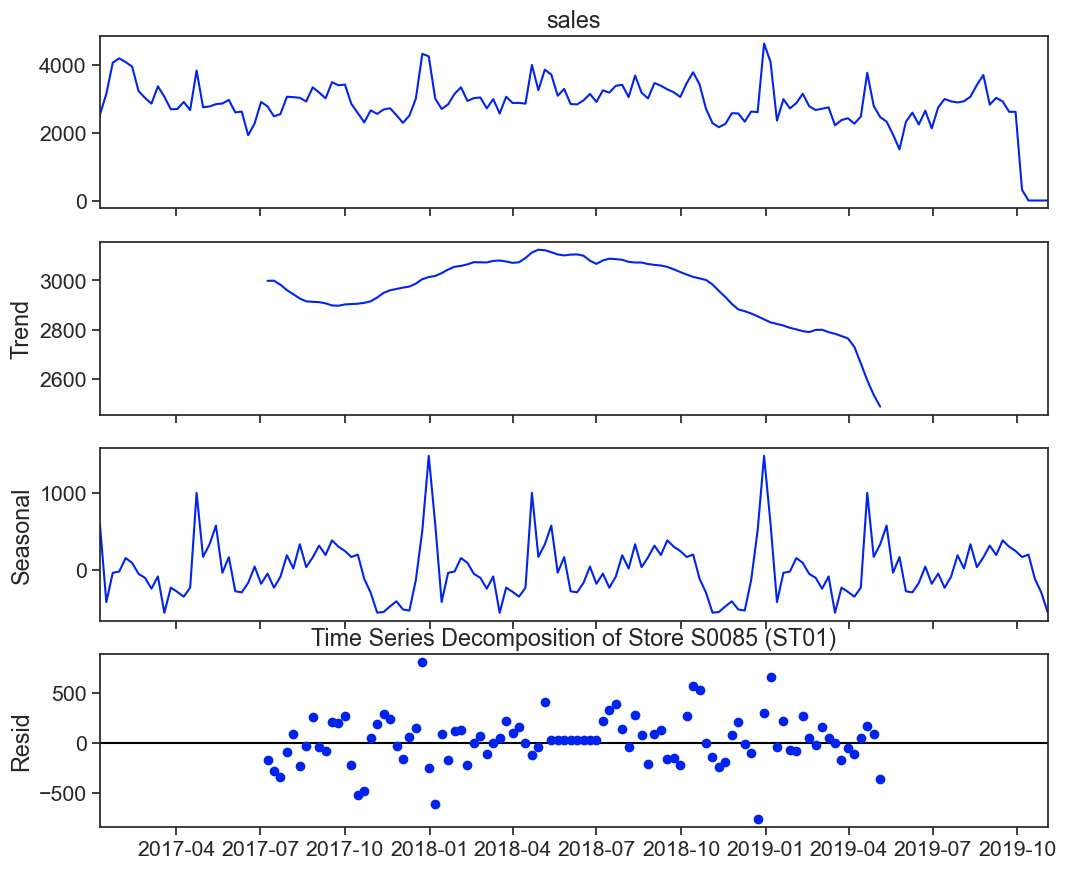

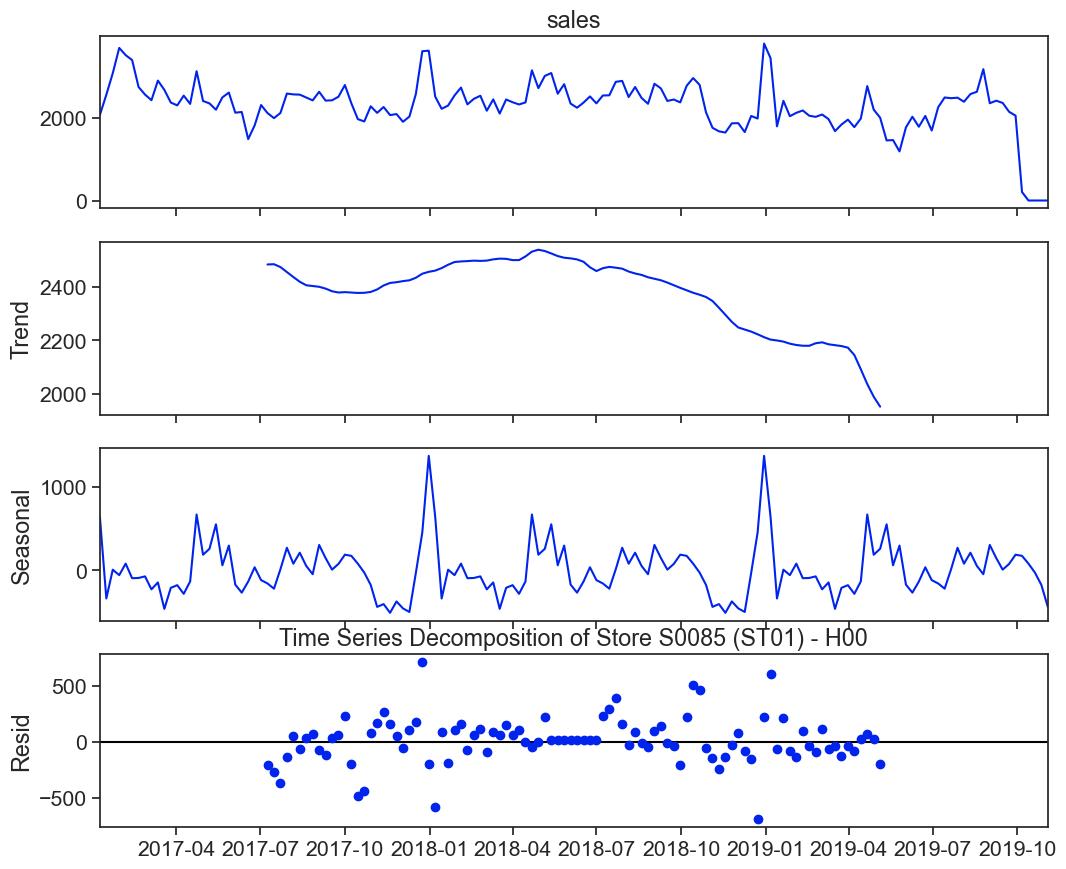

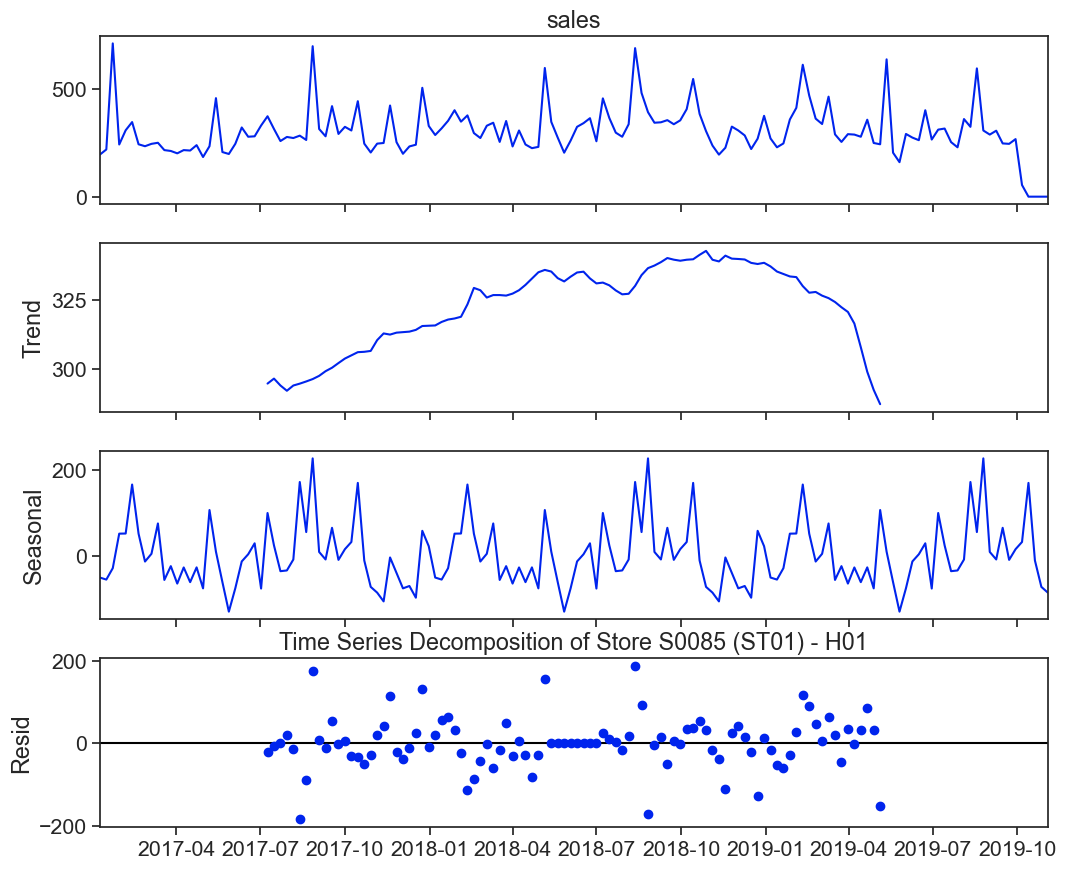

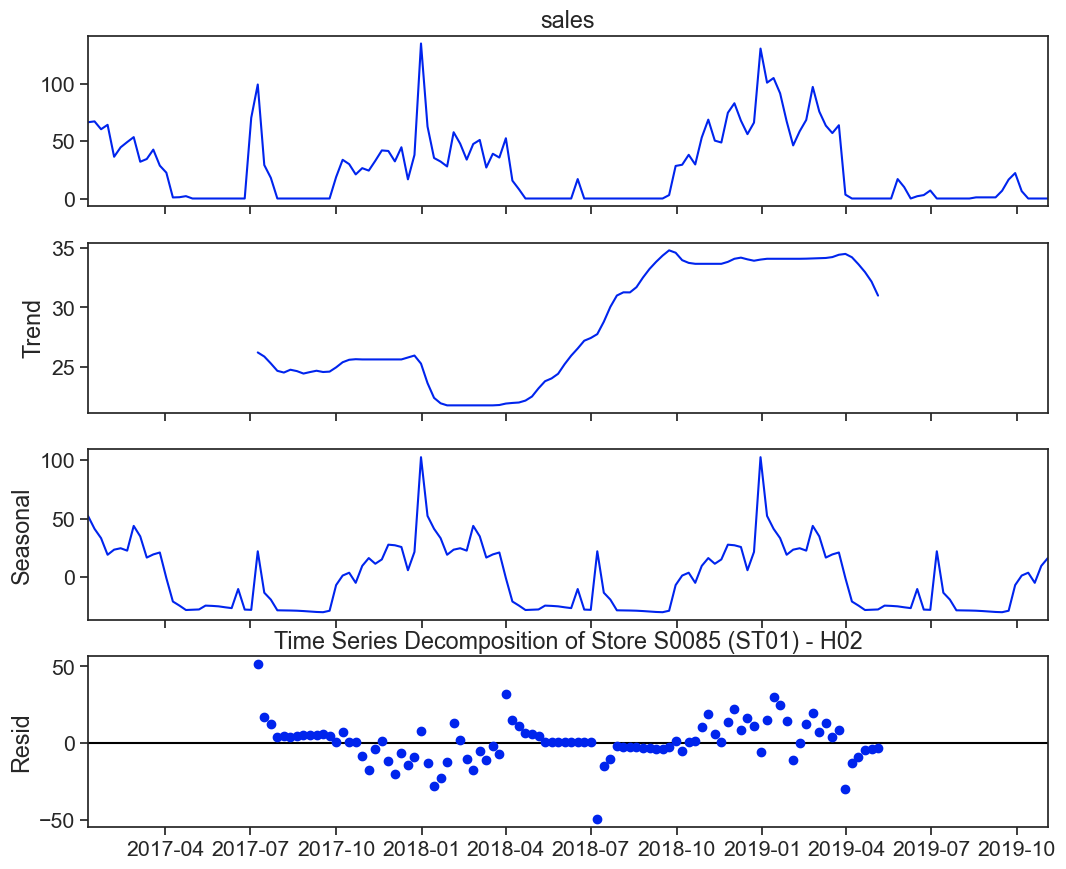

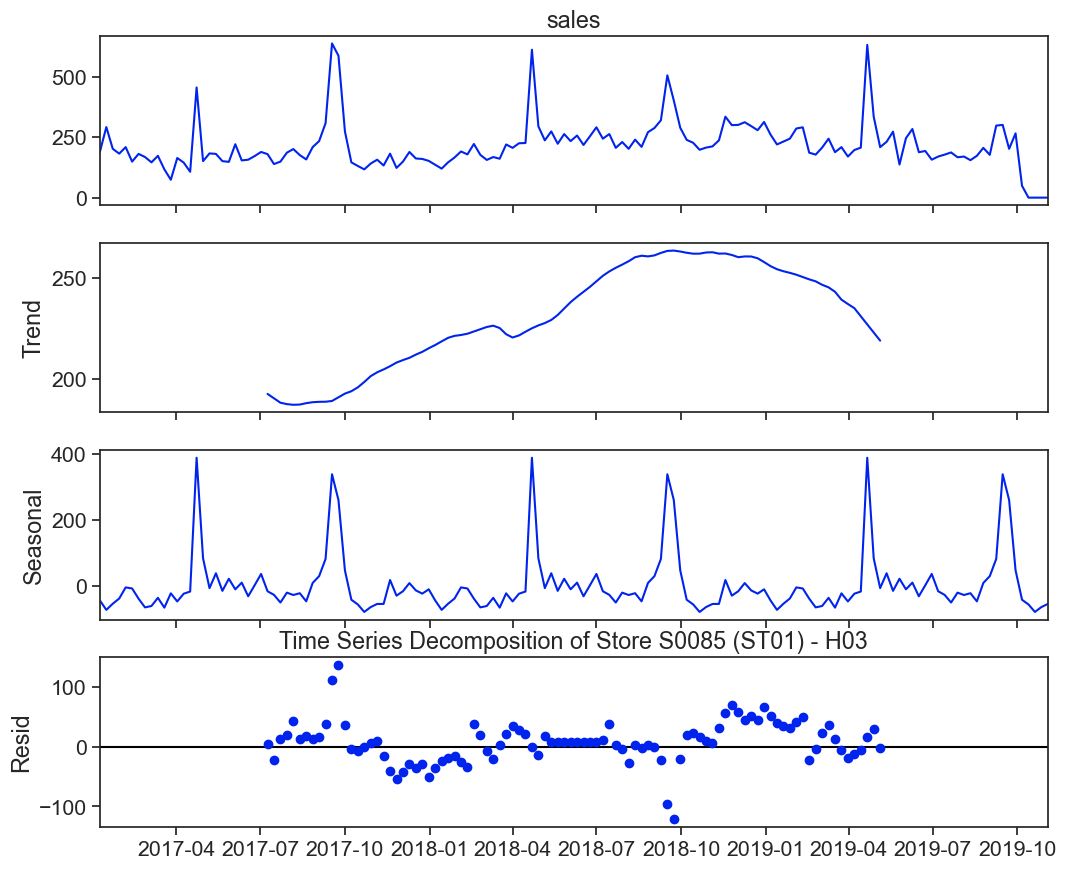

In [52]:
# Store S0085
decomposition_store(store85_prod, title =  "Time Series Decomposition of Store S0085 (ST01)", define_h1 = ["H00", "H01", "H02", "H03"])

decomposition_store(store85_prod, "Time Series Decomposition of Store S0085 (ST01) - H00", define_h1 = ["H00"])

decomposition_store(store85_prod, "Time Series Decomposition of Store S0085 (ST01) - H01", define_h1 = ["H01"])

decomposition_store(store85_prod, "Time Series Decomposition of Store S0085 (ST01) - H02", define_h1 = ["H02"])

decomposition_store(store85_prod, "Time Series Decomposition of Store S0085 (ST01) - H03", define_h1 = ["H03"])


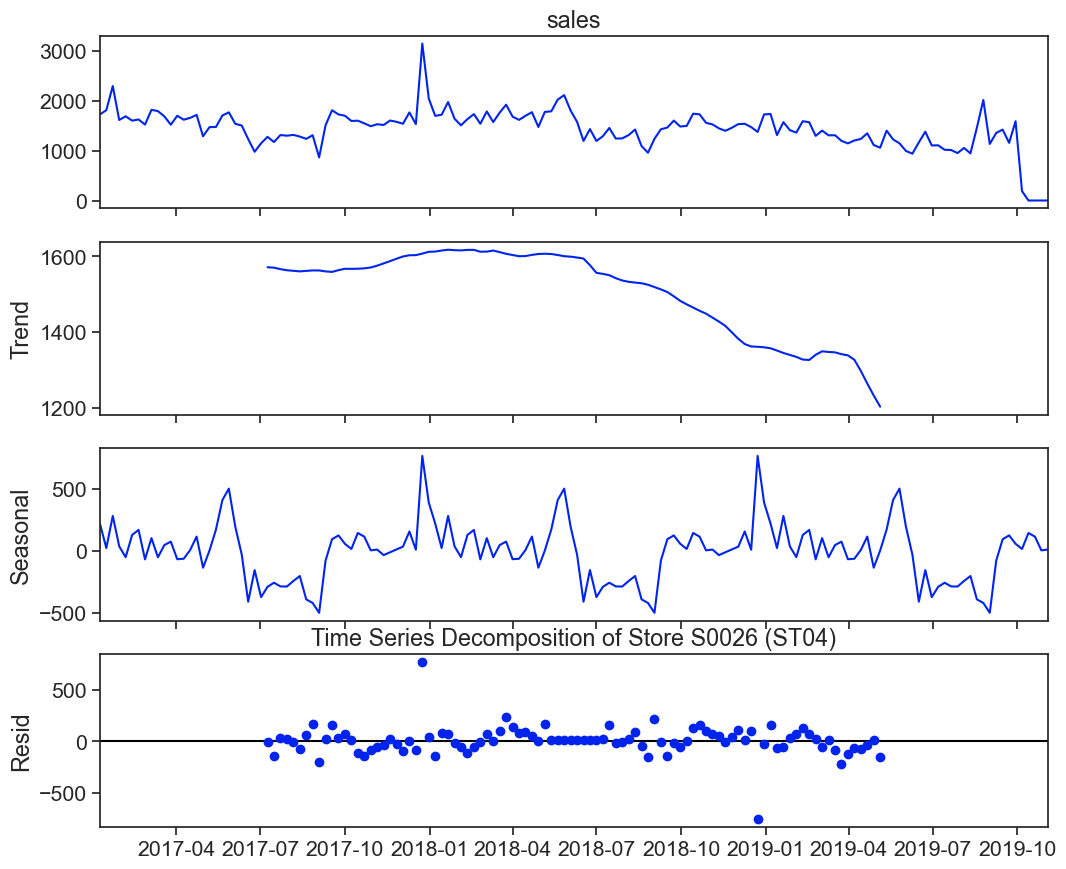

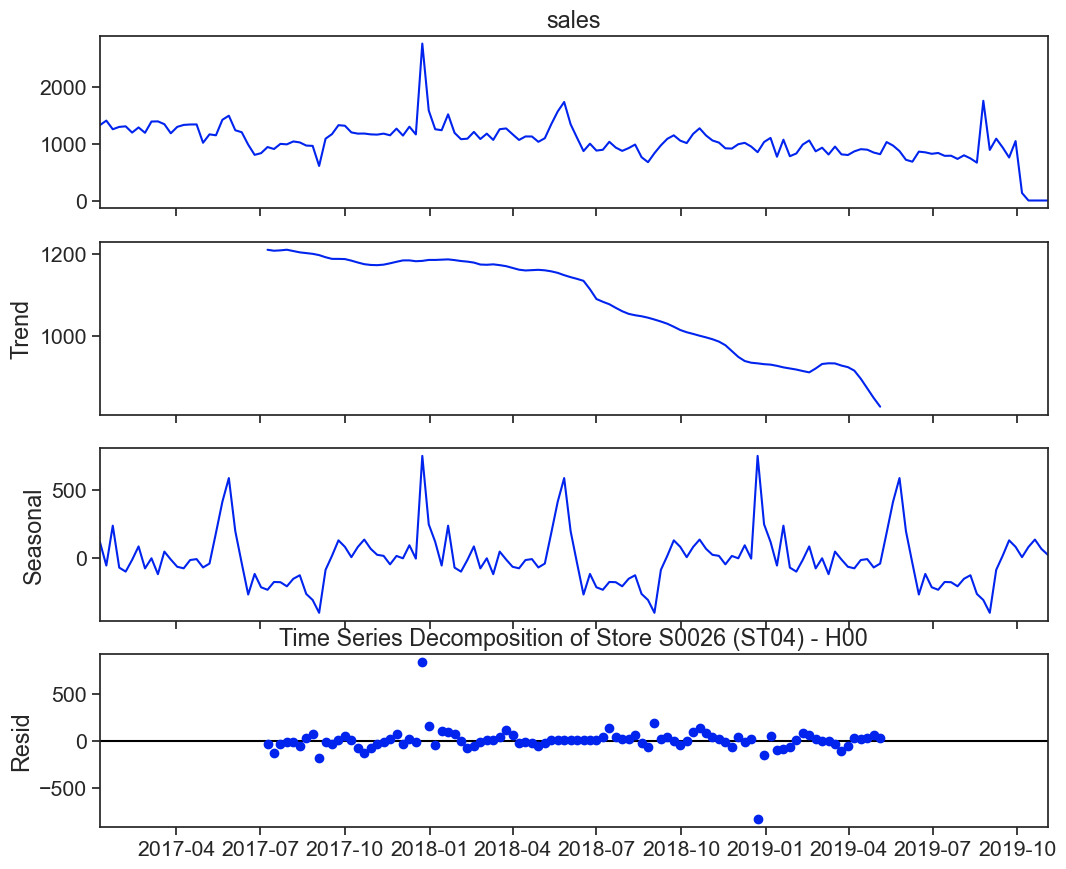

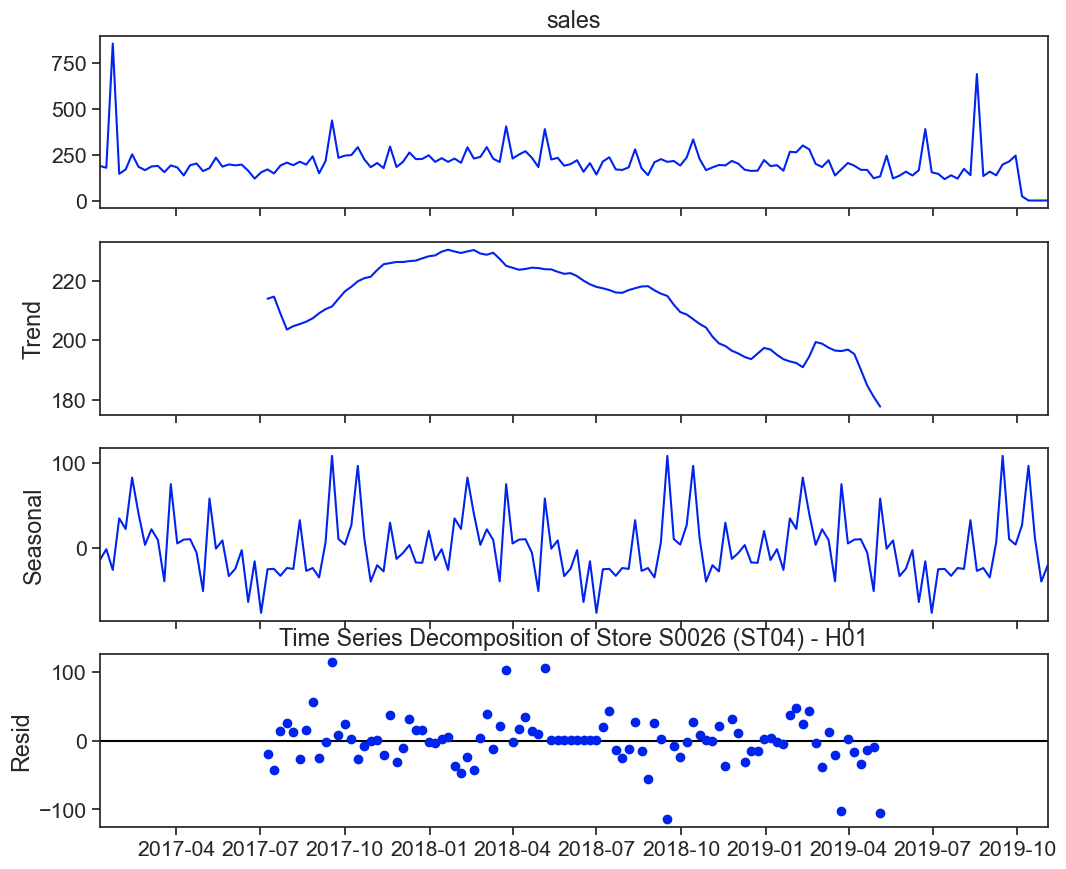

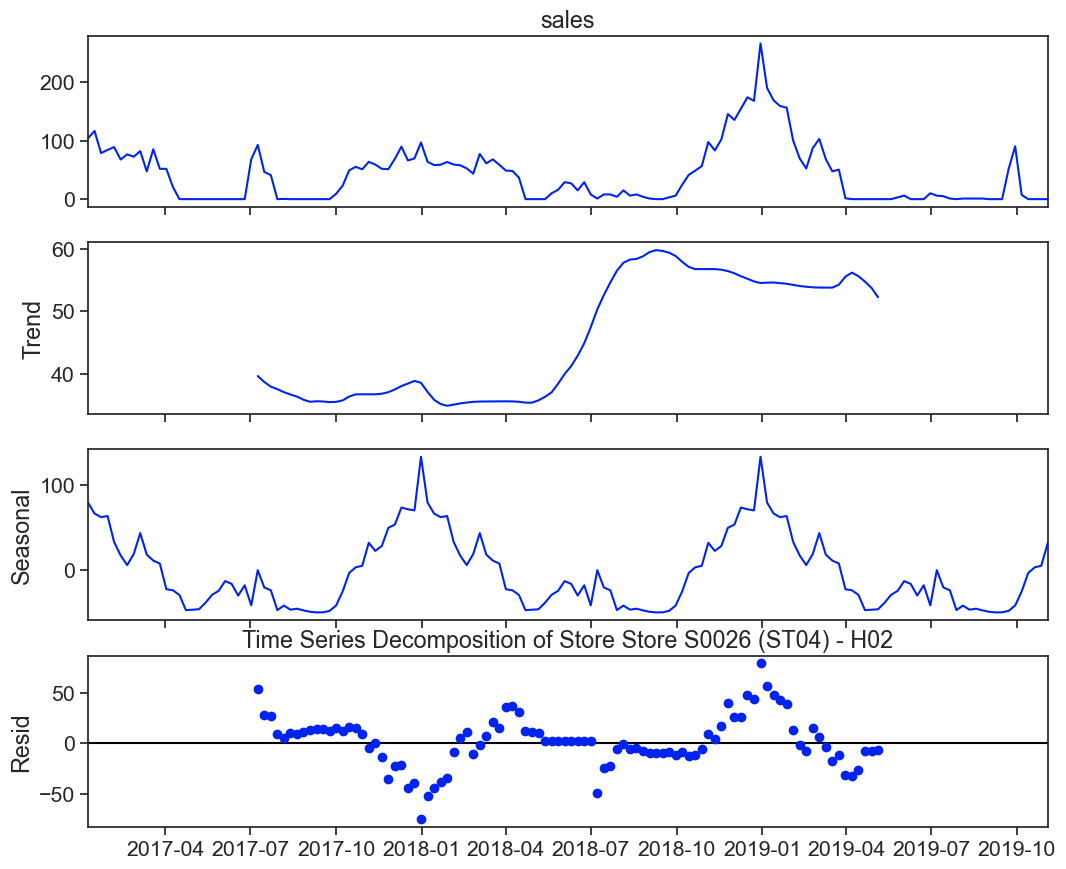

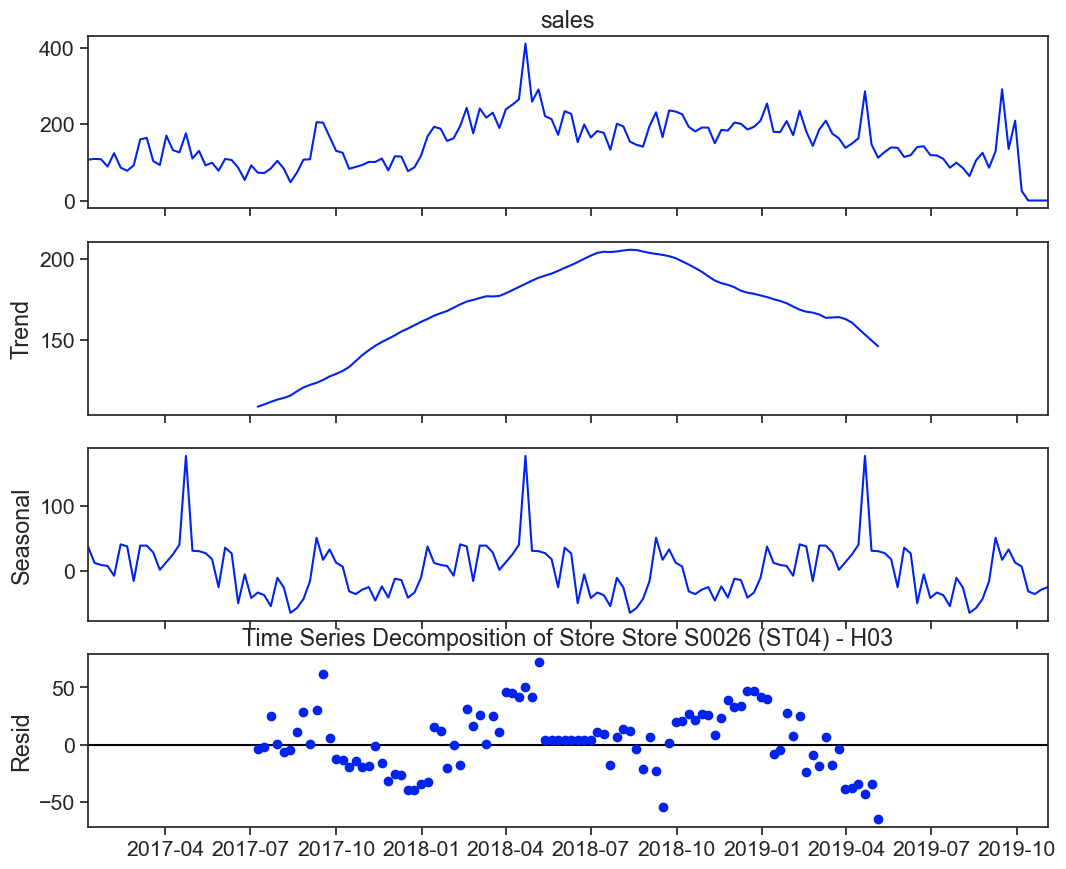

In [53]:
# Store S0026
decomposition_store(store26_prod, title =  "Time Series Decomposition of Store S0026 (ST04)", define_h1 = ["H00", "H01", "H02", "H03"])

decomposition_store(store26_prod, "Time Series Decomposition of Store S0026 (ST04) - H00", define_h1 = ["H00"])

decomposition_store(store26_prod, "Time Series Decomposition of Store S0026 (ST04) - H01", define_h1 = ["H01"])

decomposition_store(store26_prod, "Time Series Decomposition of Store Store S0026 (ST04) - H02", define_h1 = ["H02"])

decomposition_store(store26_prod, "Time Series Decomposition of Store Store S0026 (ST04) - H03", define_h1 = ["H03"])


##### 